In [1]:
!pip install pyspark
!pip install tqdm
!pip install tabulate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=3bf4f634359582d93f5529e722c7682e2acb8743ec3096197df774b09285176b
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
import numpy as np
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import DenseVector
from pyspark.sql.functions import col

import random
import math

from tqdm import tqdm
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as spark_sum


In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("abaloneAGEPrediction").getOrCreate()

In [5]:
# Reading the data
df = spark.read.csv("./abalone.csv", header=True, inferSchema=True)

# Getting the number of rows and columns
num_rows = df.count()
num_columns = len(df.columns)

# Display the number of rows and columns
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)




Number of rows: 4177
Number of columns: 9


# 1. What is an Abalone ?

#### From the Abalone entry on Wikipedia:

Abalones are marine snails. Their taxonomy puts them in the family Haliotidae which contains only one genus, Haliotis, which once contained six subgenera. These subgenera have become alternate representations of Haliotis. The number of species recognized worldwide ranges between 30 and 130 with over 230 species-level taxa described. The most comprehensive treatment of the family considers 56 species valid, with 18 additional subspecies.

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import min, max
# Find the minimum and maximum values of the 'Rings' column
agg_result = df.agg(min('Rings').alias('min_Rings'), max('Rings').alias('max_Rings')).first()

# Extract the values
min_rings = agg_result['min_Rings']
max_rings = agg_result['max_Rings']

# Display the minimum and maximum values
print("Minimum Rings:", min_rings)
print("Maximum Rings:", max_rings)

Minimum Rings: 1
Maximum Rings: 29


![Screenshot%202023-10-16%20at%2011.56.02%E2%80%AFAM.png](attachment:Screenshot%202023-10-16%20at%2011.56.02%E2%80%AFAM.png)

![jeonbok.jpg](attachment:jeonbok.jpg)

In [8]:
df.show()

+---+------+--------+------+------------+--------------+--------------+------------+-----+
|Sex|Length|Diameter|Height|Whole weight|Shucked weight|Viscera weight|Shell weight|Rings|
+---+------+--------+------+------------+--------------+--------------+------------+-----+
|  M| 0.455|   0.365| 0.095|       0.514|        0.2245|         0.101|        0.15|   15|
|  M|  0.35|   0.265|  0.09|      0.2255|        0.0995|        0.0485|        0.07|    7|
|  F|  0.53|    0.42| 0.135|       0.677|        0.2565|        0.1415|        0.21|    9|
|  M|  0.44|   0.365| 0.125|       0.516|        0.2155|         0.114|       0.155|   10|
|  I|  0.33|   0.255|  0.08|       0.205|        0.0895|        0.0395|       0.055|    7|
|  I| 0.425|     0.3| 0.095|      0.3515|         0.141|        0.0775|        0.12|    8|
|  F|  0.53|   0.415|  0.15|      0.7775|         0.237|        0.1415|        0.33|   20|
|  F| 0.545|   0.425| 0.125|       0.768|         0.294|        0.1495|        0.26|   16|

In [9]:
df.describe().show()

+-------+----+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+
|summary| Sex|             Length|           Diameter|             Height|       Whole weight|     Shucked weight|     Viscera weight|       Shell weight|             Rings|
+-------+----+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+
|  count|4177|               4177|               4177|               4177|               4177|               4177|               4177|               4177|              4177|
|   mean|NULL| 0.5239920995930099|  0.407881254488869| 0.1395163993296614|   0.82874215944458|0.35936748862820106|0.18059360785252604|0.23883085946851795| 9.933684462532918|
| stddev|NULL|0.12009291256479936|0.09923986613365941|0.04182705660725731|0.49038901823099795|0.22196294903322014|0.10961425025968

# Analysis:
In this section the distribution of each attribute is analyzed individually. We start analyzing the distribution of the target attribute Rings. The rest of the attributes are divided in groups for convenience of the analysis: a group called Size, containing attributes that represents the dimensions of an abalone, a group Weight, containing the different weight attributes and a third group composed only of the Sex attribute. The continous or quantitative attributes were analyzed using histograms and boxplots, while categorical attributes were analyzed using barplots.

## The Target Attribute:
The analysis shows that the Ring attribute values ranges from 1 to 29 rings on an abalone specimen. However, the most frequent values of Rings are highly concentrated around the median of the distribution, so that, the 2nd and 3rd quartiles are defined in a range of less than 1 std deviation. We observe that its possible to approximate the distribution of this attribute to a normal curve.

In [10]:
df.select("Rings", "Height").describe().show()

+-------+------------------+-------------------+
|summary|             Rings|             Height|
+-------+------------------+-------------------+
|  count|              4177|               4177|
|   mean| 9.933684462532918| 0.1395163993296614|
| stddev|3.2241690320681315|0.04182705660725731|
|    min|                 1|                0.0|
|    max|                29|               1.13|
+-------+------------------+-------------------+



In [11]:
null_counts = df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Display the number of null values in each column
null_counts.show()

+---+------+--------+------+------------+--------------+--------------+------------+-----+
|Sex|Length|Diameter|Height|Whole weight|Shucked weight|Viscera weight|Shell weight|Rings|
+---+------+--------+------+------------+--------------+--------------+------------+-----+
|  0|     0|       0|     0|           0|             0|             0|           0|    0|
+---+------+--------+------+------------+--------------+--------------+------------+-----+



In [13]:
pip install pyspark_dist_explore


# # Scatter plot
Relation with target column
Observation : Some features has a linear relationship with target.

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:733: FutureWarning: HiveContext is deprecated in Spark 2.0.0. Please use SparkSession.builder.enableHiveSupport().getOrCreate() instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


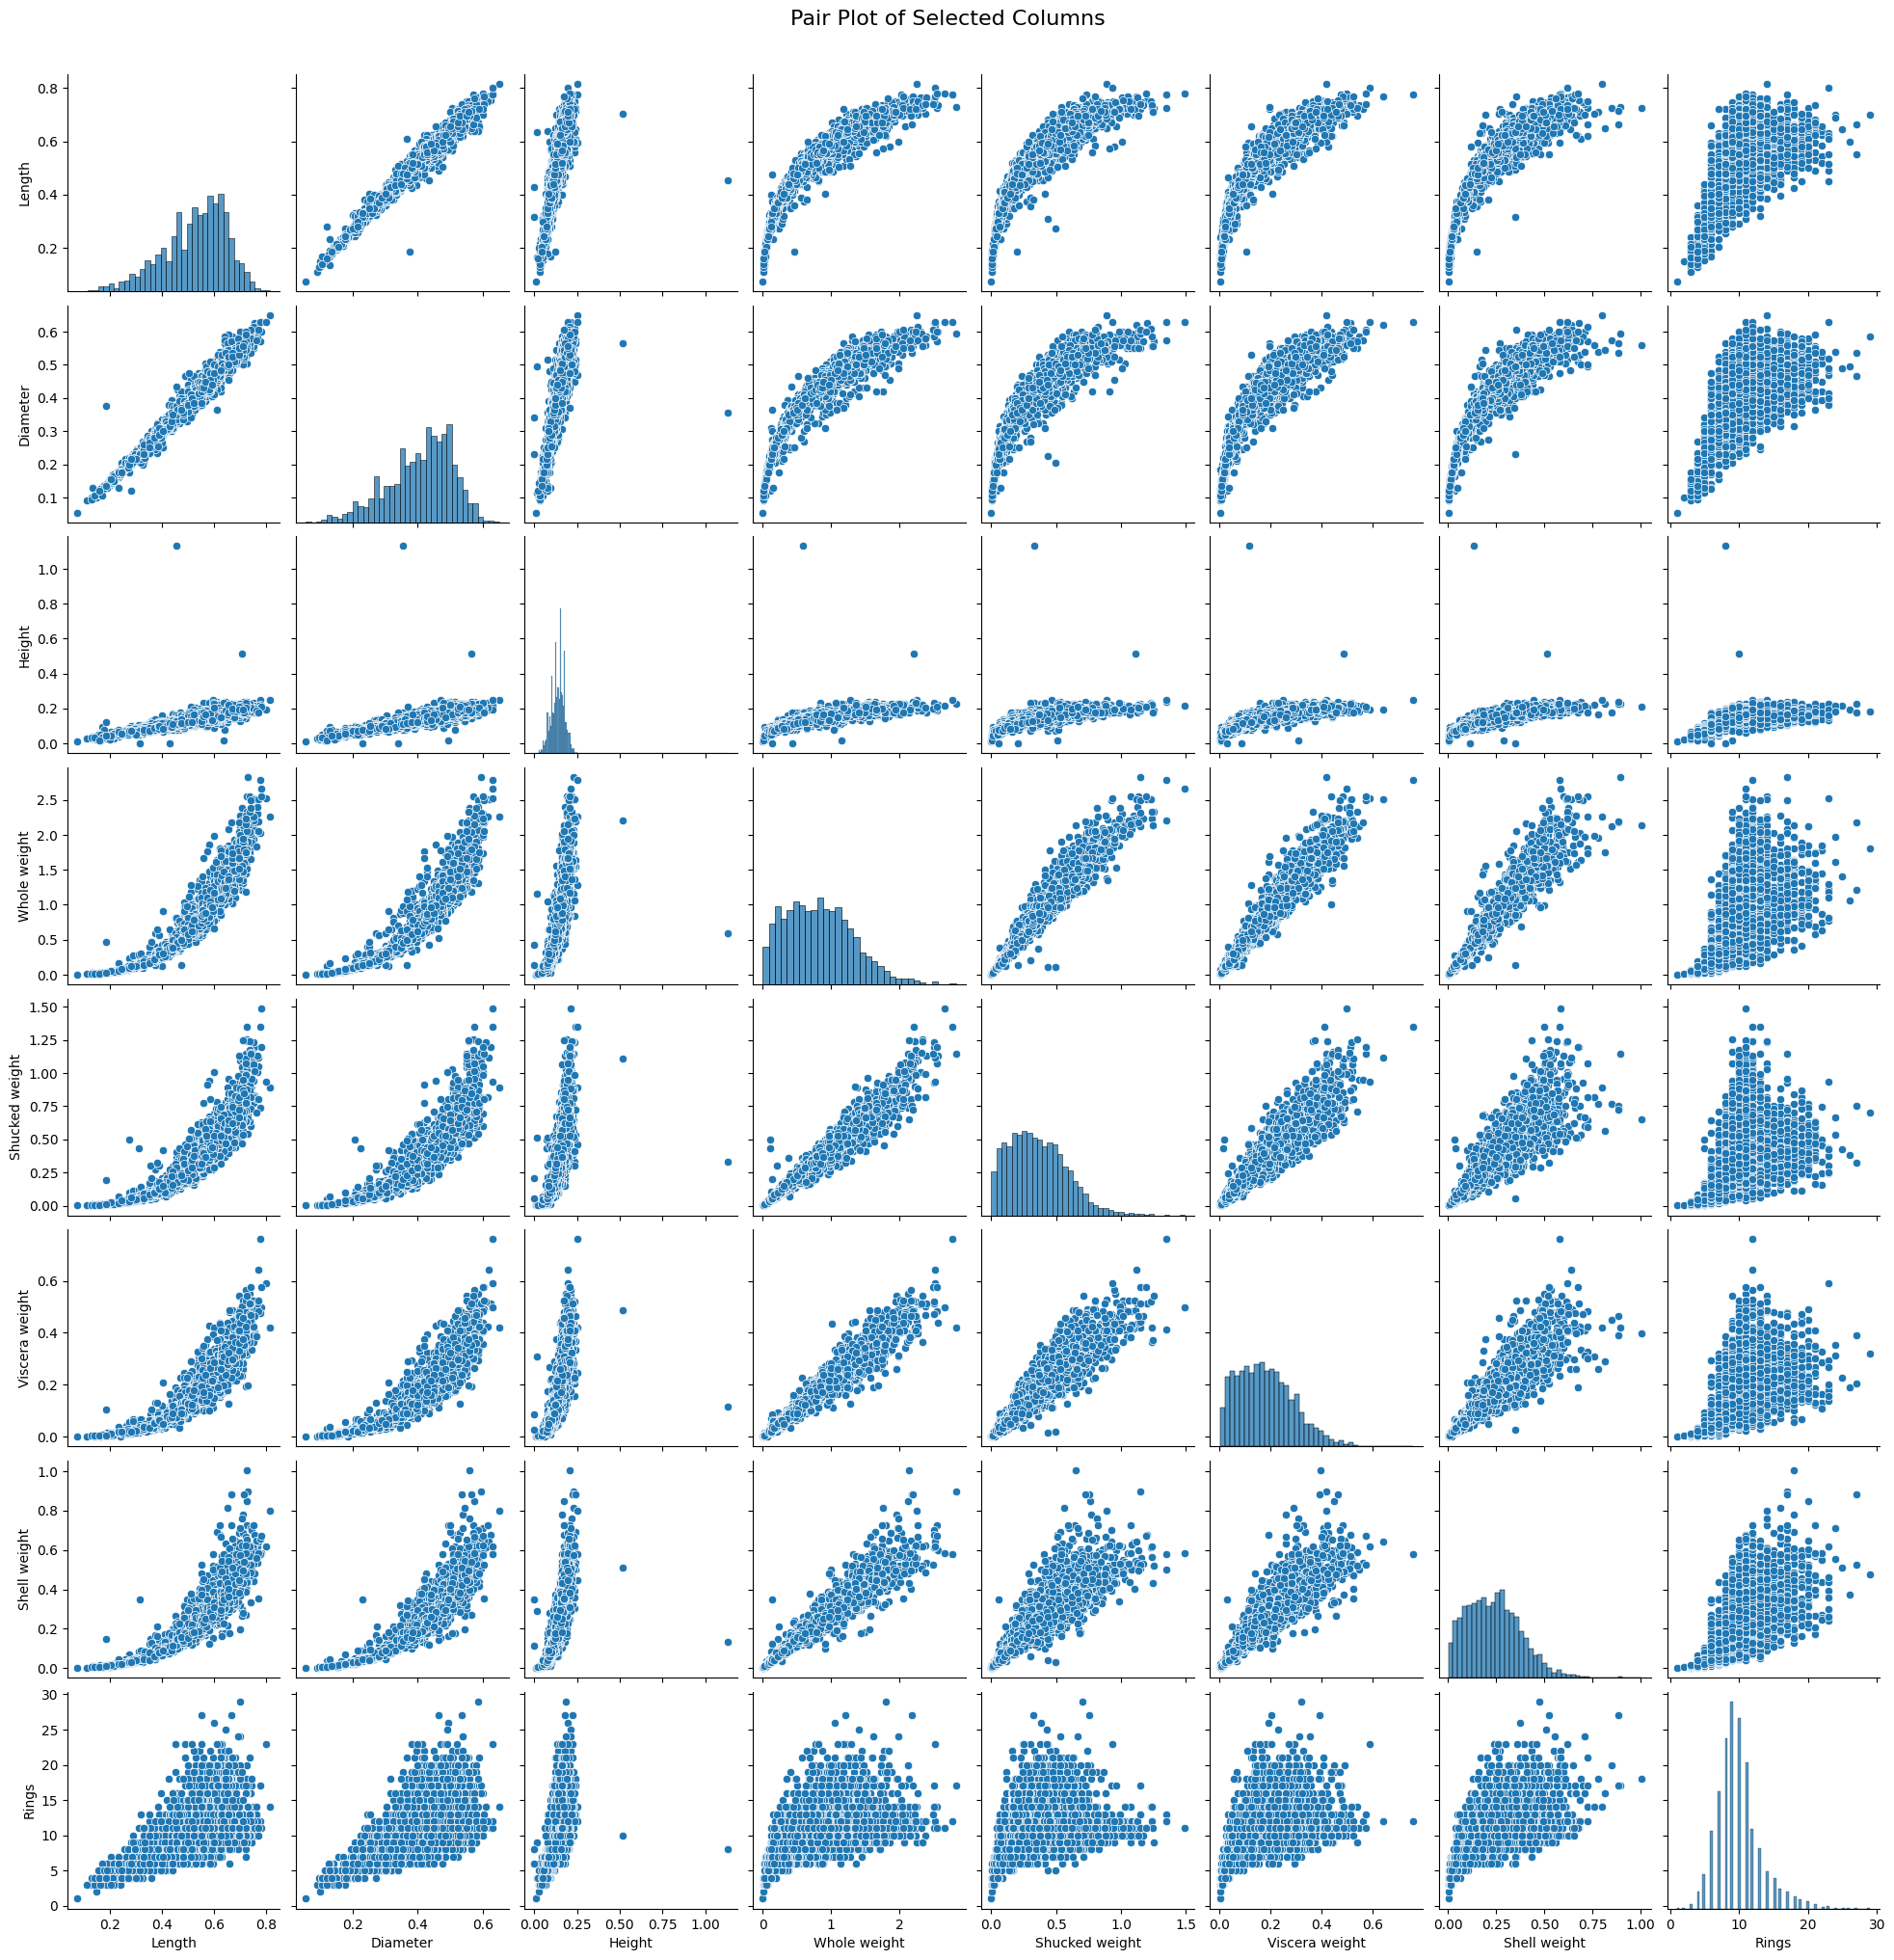

In [18]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import HiveContext
import seaborn as sns


hiveContext = HiveContext(spark)

# Reading the data
df = spark.read.csv("./abalone.csv", header=True, inferSchema=True)


selected_columns = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']

# Create a temporary view for the DataFrame
df.createOrReplaceTempView("abalone")


pair_plot_query = f"""
SELECT `Length`, `Diameter`, `Height`, `Whole weight`, `Shucked weight`, `Viscera weight`, `Shell weight`, `Rings`
FROM abalone
"""
pair_plot_data = hiveContext.sql(pair_plot_query)


sns.pairplot(pair_plot_data.toPandas())
plt.suptitle("Pair Plot of Selected Columns", y=1.02, fontsize=16)
plt.show()






In [19]:
column_names = df.columns

# Print the column names
print(column_names)

['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']


# How correlation varies with the number of rings ?
Based on the analysis, we decided to investigate the variation of the correlation regarding the number of rings in more detail. We tested for many values, and found that the region delimited by Rings < 10 has greater correlation between the independent attributes and the target variable.

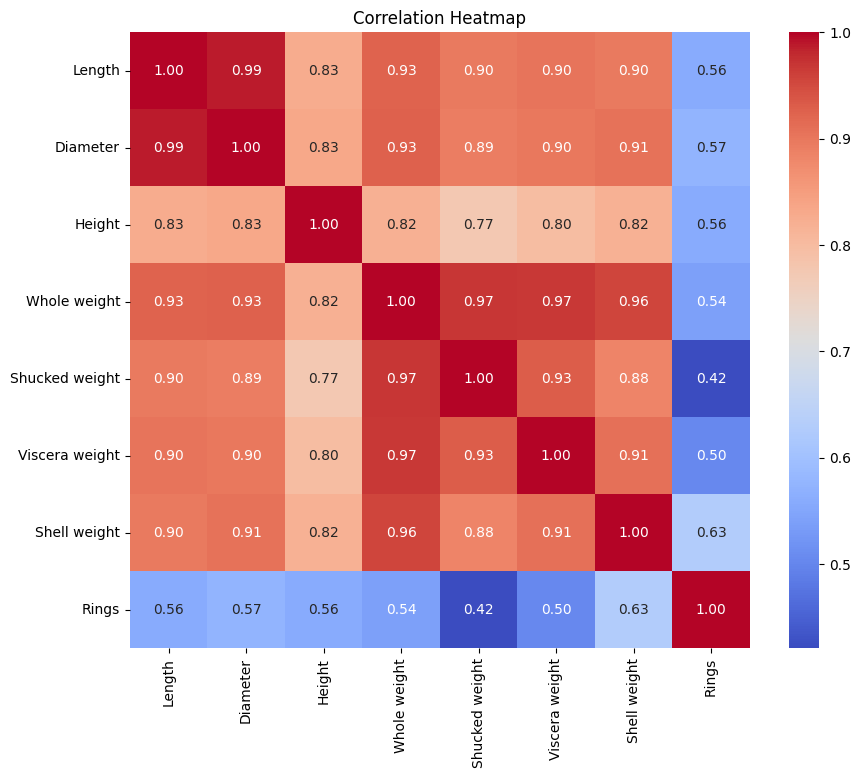

In [20]:
# Select the columns you want for the heatmap
selected_columns = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
selected_data = df.select(selected_columns).toPandas()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(selected_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


Almost everything is strongly correlated with everything else, except ring count! :( Assuming body proportions don't vary much between different abalone this makes sense.

All of the features features associated with weight are pretty much perfectly correlated with each other, with pearson coefficients > 0.95 for whole weight. This isn't surprising since they're just the weights of different parts of the same abalone. I think we can safely drop the shucked weight, viscera weight, and shell weight and just keep whole weight (PCA is probably overkill).

Length and diameter are just about perfectly correlated. The circumfrence of an ellipse is proportional to its length with the constant of proportionality determined by its eccentricity, so no surprise there. Height is strongly correlated with the remaining features, but not as strongly as, say, length with diameter. We'll replace these three features with their geometric mean. While keeping length, diameter, and height can only help with prediction, I think the benefits gained of an easier to interpret model outweight the marginal gain of predictability from keeping them.

In [21]:
# Count the values in the 'Sex' column
sex_counts = df.groupBy("Sex").count()

# Show the counts
sex_counts.show()

+---+-----+
|Sex|count|
+---+-----+
|  F| 1307|
|  M| 1528|
|  I| 1342|
+---+-----+



#  BoxPlot
### The box plot displays 'Rings' on the x-axis, 'Length' on the y-axis, and differentiates data points by 'Sex' using distinct colors


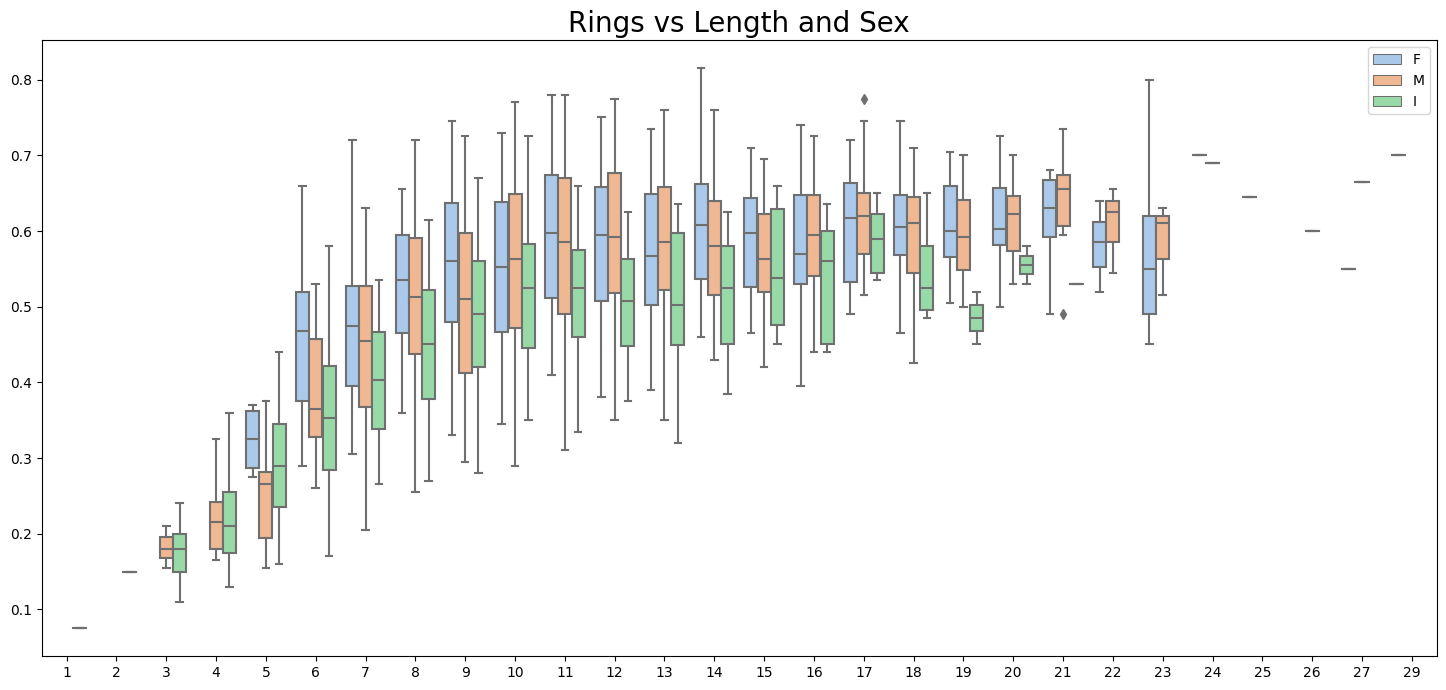

In [22]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean
import seaborn as sns



# Define the columns for the box plot
x_column = 'Rings'
y_column = 'Length'
hue_column = 'Sex'

# Group and aggregate the data
grouped_data = df.groupBy(x_column, y_column, hue_column).agg(mean(x_column).alias(x_column + "_mean"))

# Collect data to the driver
plot_data = grouped_data.collect()

# Extract the data from the collected rows
x_data = [row[x_column] for row in plot_data]
y_data = [row[y_column] for row in plot_data]
hue_data = [row[hue_column] for row in plot_data]

# Create the box plot using Matplotlib
plt.figure(figsize=(18, 8))
sns.boxplot(x=x_data, y=y_data, hue=hue_data, palette='pastel')
plt.title(f'{x_column} vs {y_column} and {hue_column}', fontsize=20)
plt.show()




# The violin plots bellow show that the median of Size attributes increases as instances are grouped by Rings:


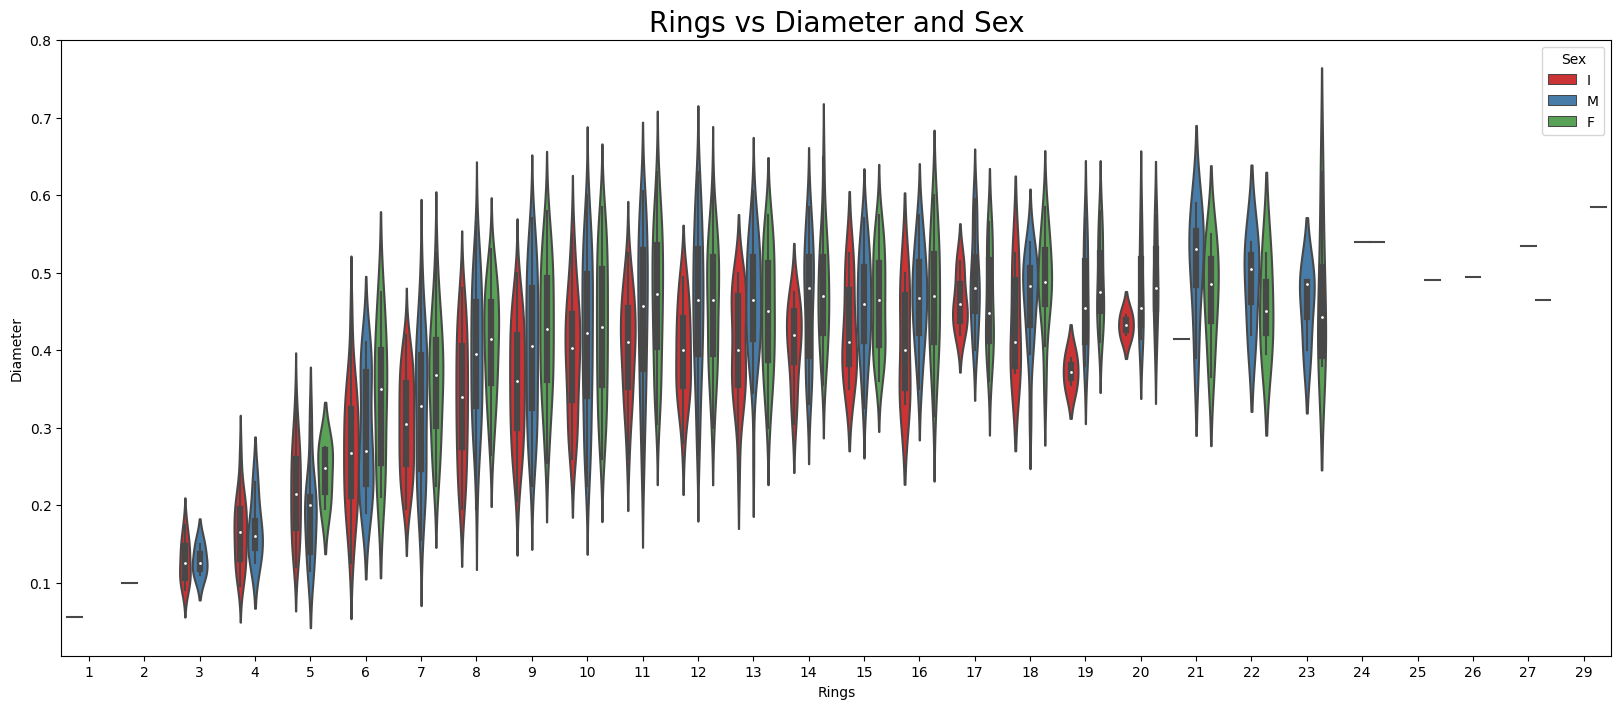

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
import pyspark.sql.functions as F


# Define the columns for the violin plot
x_column = 'Rings'
y_column = 'Diameter'
hue_column = 'Sex'

# Group and aggregate the data for the violin plot
grouped_data = df.groupBy(x_column, y_column, hue_column).agg(F.count(hue_column).alias('Count'))

# Create the violin plot using Matplotlib and Seaborn style
plt.figure(figsize=(20, 8))
sns.violinplot(data=grouped_data.toPandas(), x=x_column, y=y_column, hue=hue_column, palette='Set1')
plt.title(f'{x_column} vs {y_column} and {hue_column}', fontsize=20)
plt.show()


# Anlaysis btw Rings and Whole weights:

The plot helps us understand the distribution and density of 'Whole weight' observations across different 'Rings' values. It is useful for identifying the concentration of data points at various age levels ('Rings') and spotting any potential outliers or gaps in the data.

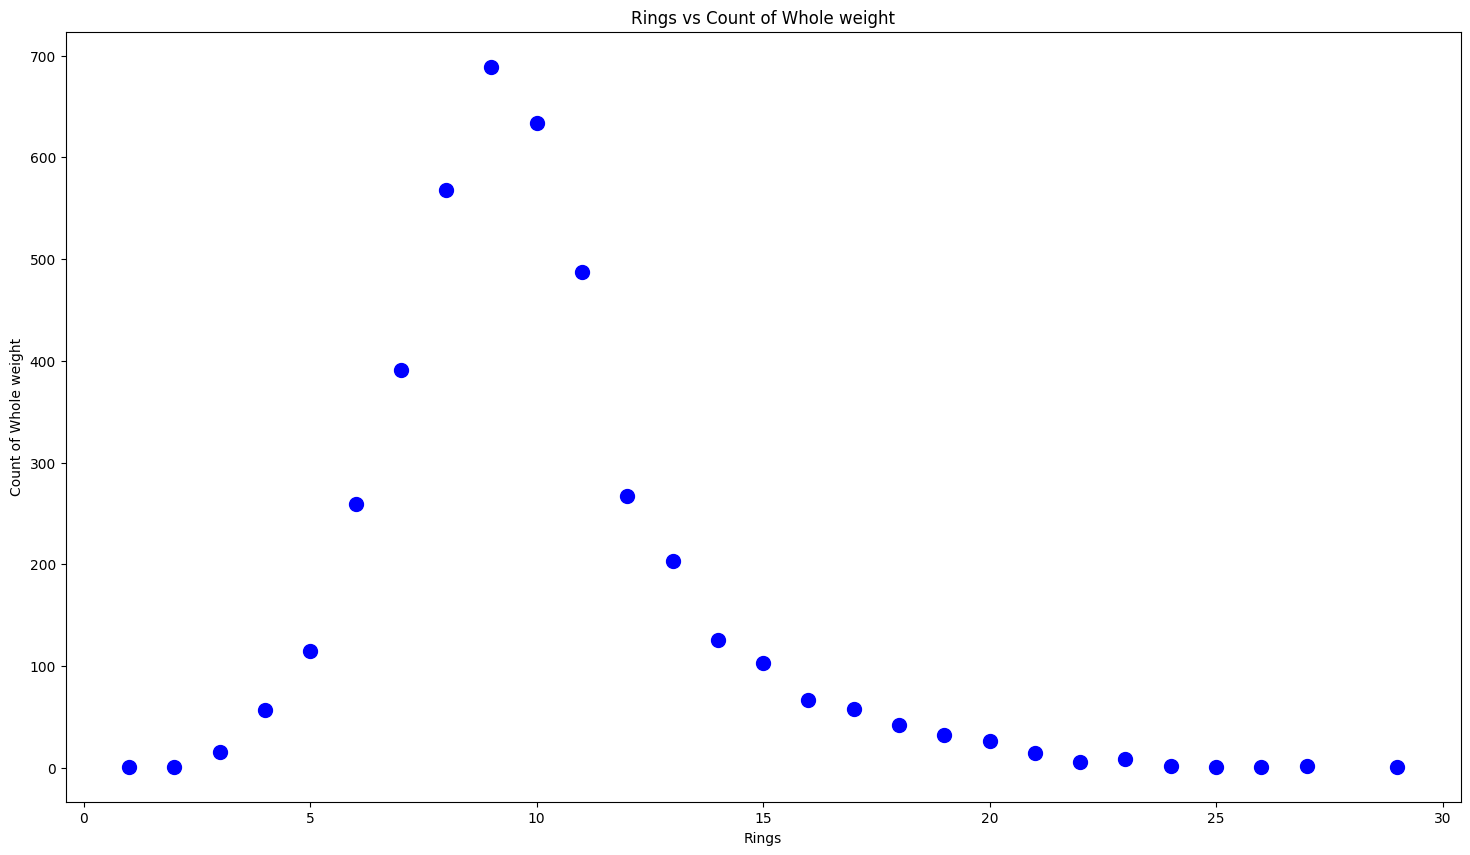

In [25]:
from pyspark.sql.functions import mean, count
x_column = 'Rings'
y_column = 'Whole weight'

# Perform aggregation and grouping
aggregated_data = df.groupBy(x_column).agg(mean('Whole weight').alias('Mean_Whole_weight'),
                                           count('Whole weight').alias('Count_Whole_weight'))


aggregated_data.createOrReplaceTempView("aggregated_data")

# Collect the data to the driver
aggregated_data_collect = spark.sql("SELECT Rings, Mean_Whole_weight, Count_Whole_weight FROM aggregated_data").collect()

# Extract the data
x_data = [row['Rings'] for row in aggregated_data_collect]
y_data = [row['Count_Whole_weight'] for row in aggregated_data_collect]


plt.figure(figsize=(18, 10))
plt.scatter(x_data, y_data, s=100, c='b', marker='o')
plt.xlabel(x_column)
plt.ylabel('Count of Whole weight')
plt.title(f'{x_column} vs Count of Whole weight')
plt.show()





# Sex:
The Sex attribute is a categorical variable for which the possibles values are: M for Male, F for Female and I of Infant (an abalone which is not adult). We analyzed the count of each category with a bar plot, and concluded that relative to this attribute, the dataset is balanced.

# Observation:

The resulting plot can be explained as follows

The bar plot provides a clear representation of the distribution of data in the 'Sex' category within the dataset. It illustrates the count of occurrences for each 'Sex' category, which is a categorical variable.

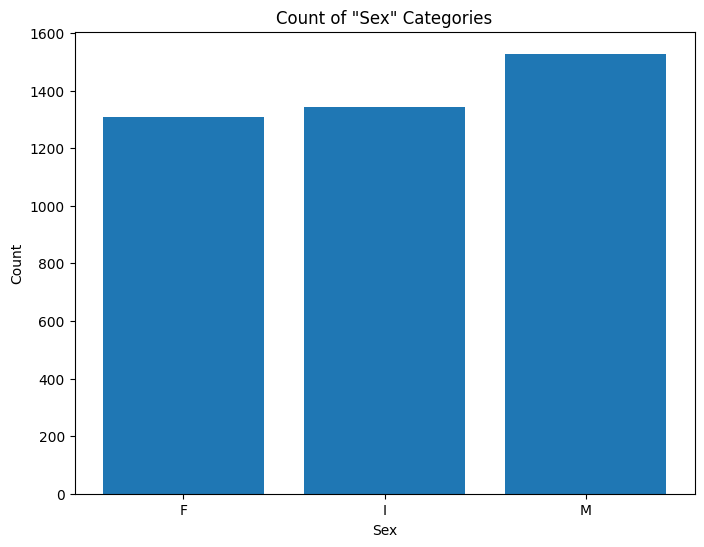

In [26]:
# Calculate the count of each "Sex" category
sex_counts = df.groupBy("Sex").count().orderBy("Sex")

sex_counts_data = sex_counts.collect()

# Separate labels and counts
sex_labels = [row["Sex"] for row in sex_counts_data]
sex_count_values = [row["count"] for row in sex_counts_data]


plt.figure(figsize=(8, 6))
plt.bar(sex_labels, sex_count_values)
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Count of "Sex" Categories')
plt.show()




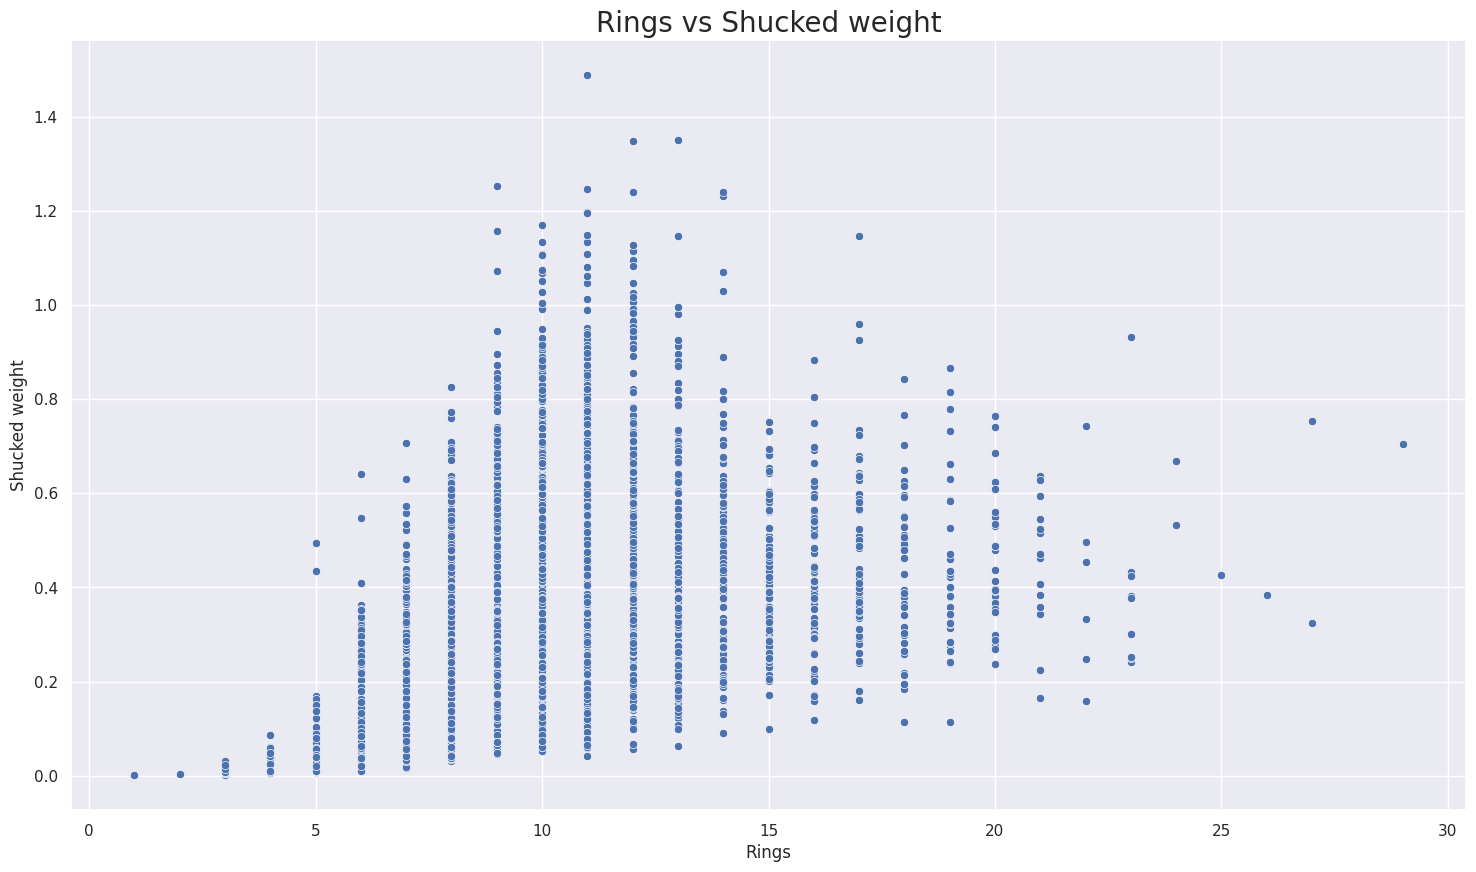

In [27]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import seaborn as sns

# Read the data
df = spark.read.csv("./abalone.csv", header=True, inferSchema=True)

# Define the columns for the analysis
x_column = 'Rings'
y_column = 'Shucked weight'

# Create a swarm plot using Matplotlib and Seaborn
plt.figure(figsize=(18, 10))
sns.set(style="darkgrid")
sns.scatterplot(data=df.select(x_column, y_column).toPandas(), x=x_column, y=y_column)
plt.title(f'{x_column} vs {y_column}', fontsize=20)
plt.show()




This visualization effectively showcases the distribution of 'Shucked weight,' representing the weight of the edible meat, with respect to the age of the abalones

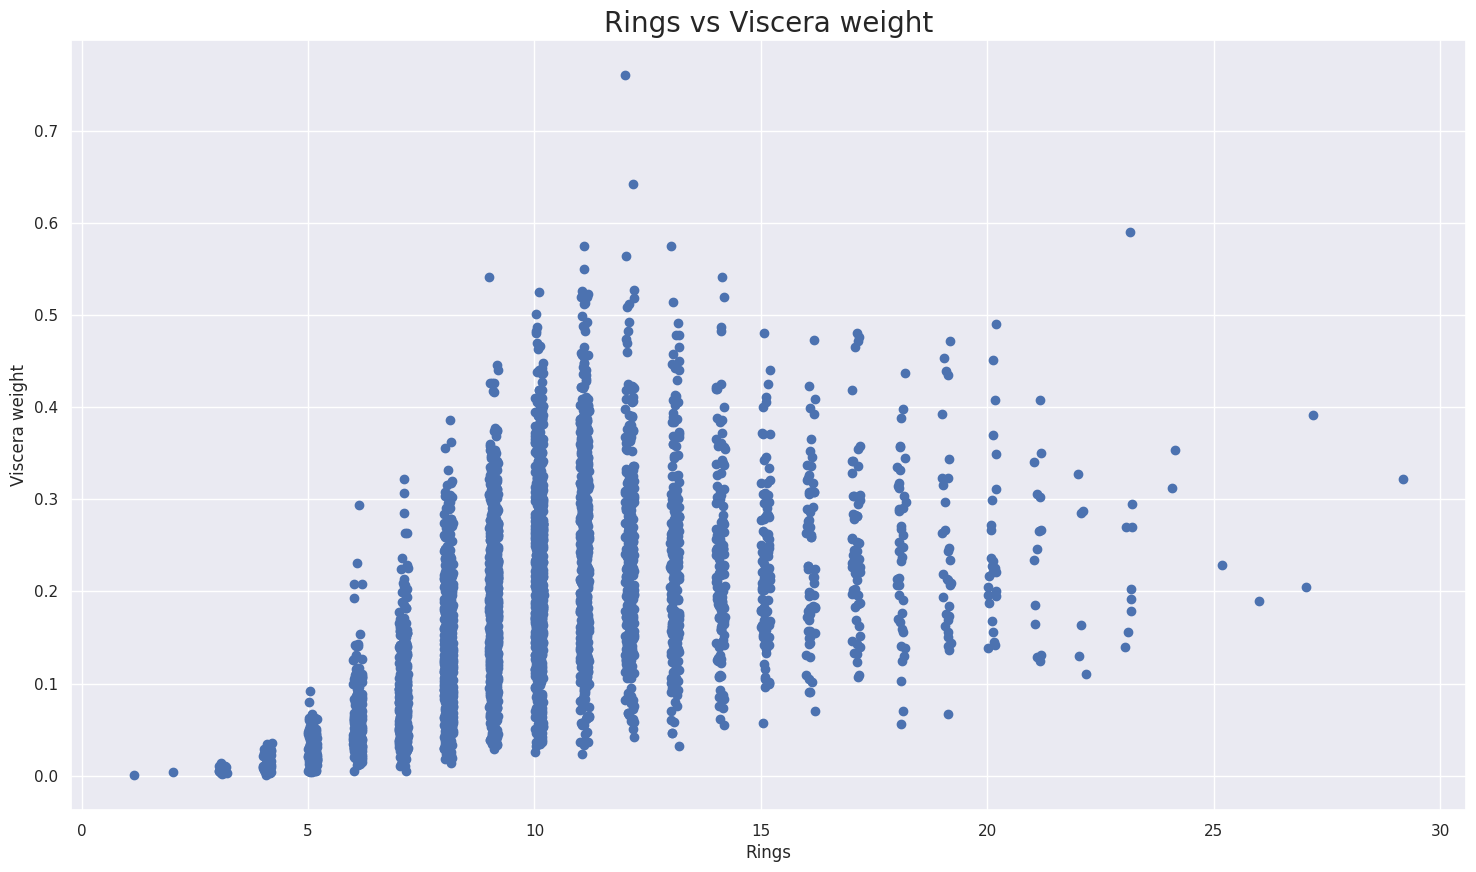

In [29]:
from pyspark.sql.functions import rand, col
# Define the columns for the strip plot
x_column = 'Rings'
y_column = 'Viscera weight'
jittered_column = 'jittered'

# Create a new column for jittered values to avoid overlapping data points
df = df.withColumn(jittered_column, rand() / 5 + col(x_column))

# Create a strip plot using Matplotlib
plt.figure(figsize=(18, 10))
x_values = df.select(jittered_column).rdd.flatMap(lambda x: x).collect()
y_values = df.select(y_column).rdd.flatMap(lambda x: x).collect()
plt.scatter(x_values, y_values)
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title(f'{x_column} vs {y_column}', fontsize=20)
plt.show()



This visualization, created for the dataset involving 'Abalone Age Prediction,' examines the relationship between 'Rings' (a proxy for abalone age) and 'Viscera weight' (the weight of the abalone's gut, often considered the viscera). To prevent overlapping data points and enhance clarity, jittering is introduced by adding a random fraction to the 'Rings' values and creating a new column named 'jittered.' The scatter plot represents the data, where the x-axis corresponds to the jittered 'Rings' values, introducing slight randomness to avoid overlapping points, and the y-axis represents 'Viscera weight.' Each point in the plot represents an individual data observation, helping visualize the distribution and density of 'Viscera weight' in relation to the age of abalones. The plot aids in identifying patterns or trends in the dataset, such as whether 'Viscera weight' tends to vary with the age of abalones, providing valuable insights into this particular aspect of abalone growth and biology.

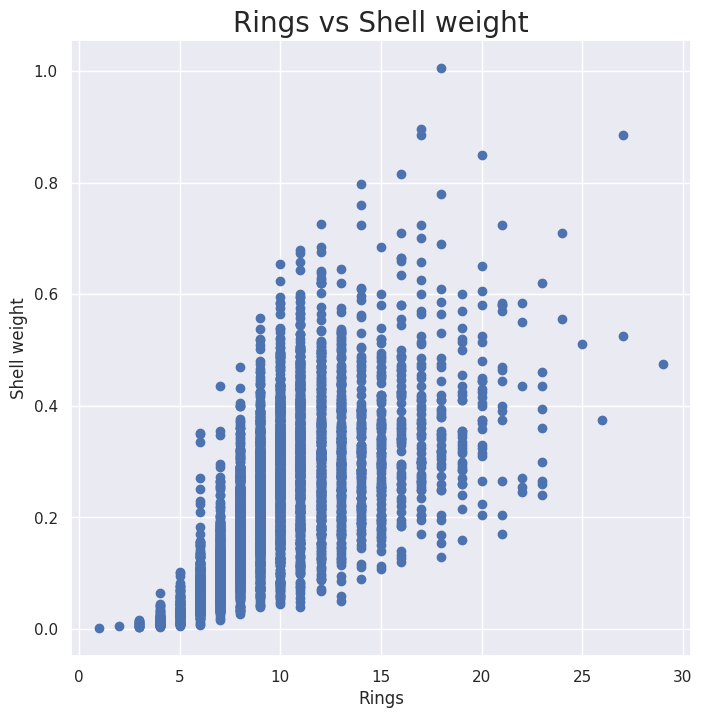

In [30]:
# Define the columns for the plot
x_column = 'Rings'
y_column = 'Shell weight'

# Select the columns of interest
data = df.select(x_column, y_column)

# Collect the data to the driver
x_values = data.rdd.map(lambda x: x[0]).collect()
y_values = data.rdd.map(lambda x: x[1]).collect()

# Create a scatter plot using Matplotlib
plt.figure(figsize=(8, 8))
plt.scatter(x_values, y_values)
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title(f'{x_column} vs {y_column}', fontsize=20)
plt.show()



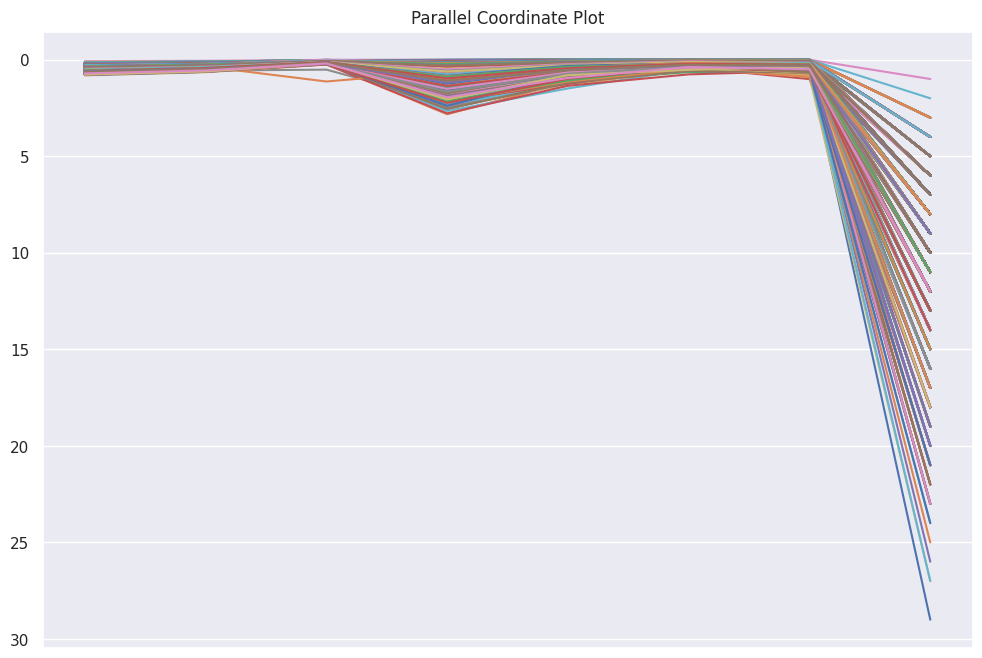

In [31]:
# Select the columns for the parallel coordinate plot
columns_to_plot = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']

# Extract the relevant data from the DataFrame
data = df.select(columns_to_plot).rdd.map(list).collect()

# Create a parallel coordinate plot
plt.figure(figsize=(12, 8))
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().invert_yaxis()
plt.title("Parallel Coordinate Plot")

for i in range(len(data)):
    plt.plot(range(len(columns_to_plot)), data[i])

plt.xticks(range(len(columns_to_plot)), columns_to_plot, rotation='vertical')
plt.show()



# Nested Donut Plot

The nested donut plot you've created illustrates the distribution of 'Sex' categories within various 'Rings' values in the Abalone dataset. The outer donut chart displays the proportions of 'Male,' 'Female,' and 'Infant' abalones in the dataset, allowing you to gauge the relative prevalence of each 'Sex' category. Within each 'Sex' category slice, the inner segments of the plot break down the data by different 'Rings' values, revealing how different age groups are distributed among the 'Sex' categories. This visualization enables you to discern the interplay between abalones' genders and their age, providing insights into the dataset's composition and structure

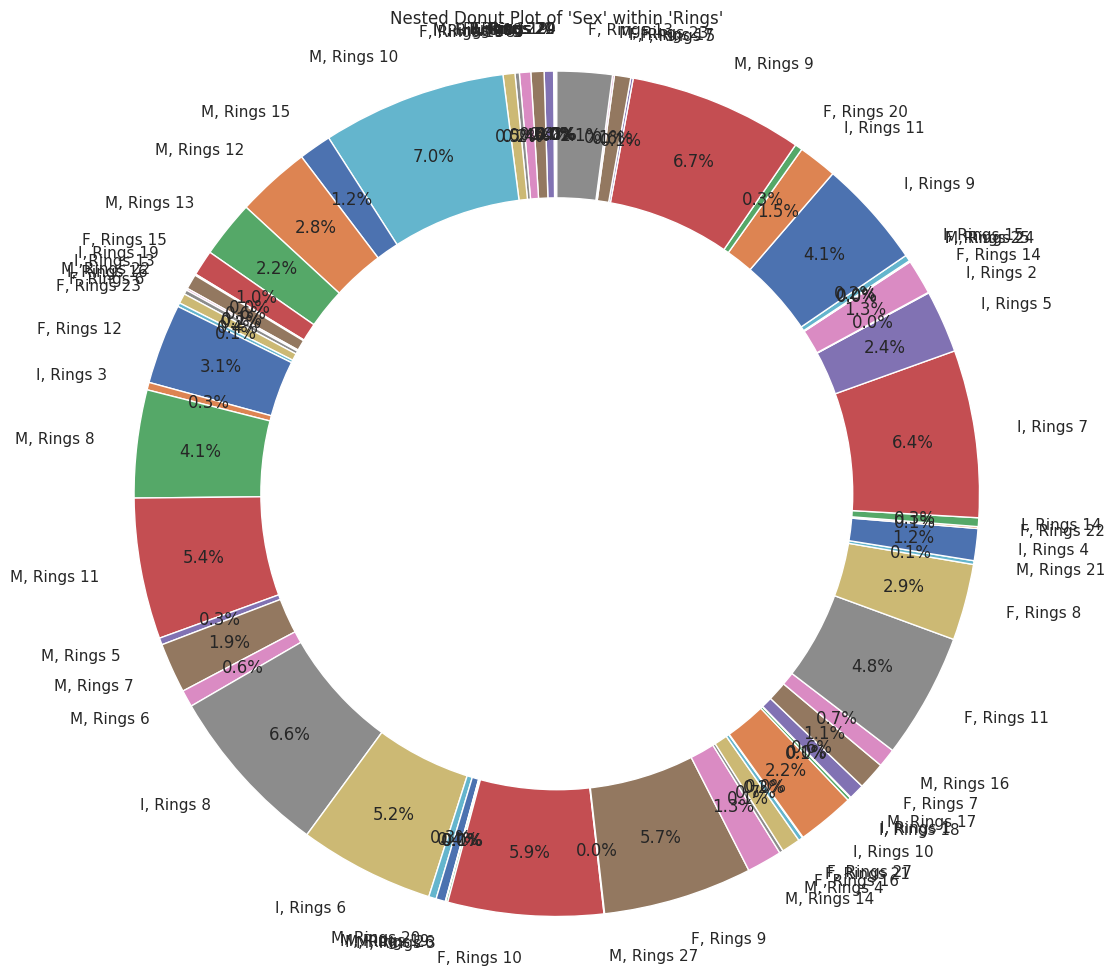

In [32]:
# Select the columns for the nested donut plot
sex_rings_df = df.select("Sex", "Rings")

# Group the data to count occurrences of each combination
sex_rings_counts = sex_rings_df.groupBy("Sex", "Rings").count().collect()

# Extract data from the collected DataFrame for visualization
labels = [f"{row['Sex']}, Rings {row['Rings']}" for row in sex_rings_counts]
sizes = [row['count'] for row in sex_rings_counts]

# Create a nested donut plot
fig, ax = plt.subplots(figsize=(12, 12))

# Outer donut plot
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
# Inner donut plot (a white circle to create the "donut" effect)
inner_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(inner_circle)

# Equal aspect ratio ensures that the pie is drawn as a circle
ax.axis('equal')

plt.title("Nested Donut Plot of 'Sex' within 'Rings'")
plt.show()





# The radar chart

I have generated provides a visual representation of selected feature values for a single data point in the Abalone age prediction dataset. Each spoke in the chart corresponds to a feature such as 'Sex,' 'Length,' 'Diameter,' 'Whole weight,' 'Viscera weight,' and 'Shell weight.' The length of each spoke signifies the magnitude of the associated feature for this specific abalone. The chart helps assess the relative importance and values of these features, offering insights into their contributions to the age prediction task. The filled area inside the chart adds clarity to the comparison of feature values, making it a valuable tool for understanding the feature characteristics of individual abalones within the dataset. This shows that lenght and sex has no usecase with determing the age..

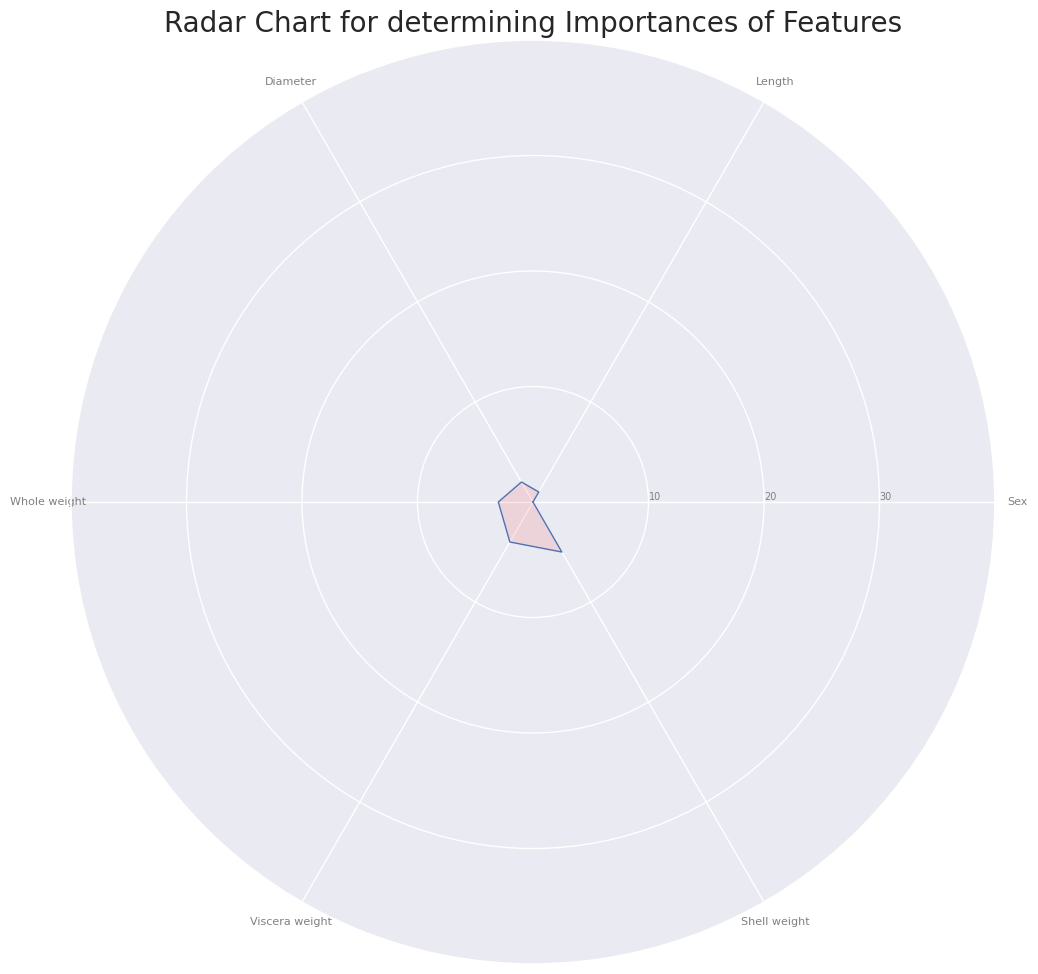

In [36]:
import numpy as np

categories = ['Sex', 'Length', 'Diameter', 'Whole weight', 'Viscera weight', 'Shell weight']

data = df.select(categories).limit(1)
values = data.rdd.flatMap(lambda row: row).collect()

values += values[:1]

N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(12, 12))

ax = plt.subplot(111, polar=True)

plt.xticks(angles[:-1], categories, color='grey', size=8)

# Draw y-labels
ax.set_rlabel_position(0)
plt.yticks([10, 20, 30], ["10", "20", "30"], color="grey", size=7)
plt.ylim(0, 40)

# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
plt.title('Radar Chart for determining Importances of Features', fontsize=20)
ax.fill(angles, values, 'red', alpha=0.1)

plt.show()


# Summary of DATA:

The provided summary statistics offer an overview of key characteristics for various attributes in the dataset.

For each attribute, including 'Length,' 'Diameter,' 'Height,' 'Whole weight,' 'Shucked weight,' 'Viscera weight,' 'Shell weight,' and 'Rings,' the summary presents the following information: the count of data points, which is 4177 for each attribute; the mean value, which indicates the average value across the dataset; the standard deviation, which quantifies the degree of variation or spread in the data; the minimum value (Min), representing the lowest observed value within the dataset; and the maximum value (Max), signifying the highest observed value.

These statistics provide valuable insights into the central tendency, dispersion, and range of each attribute, aiding in a better understanding of the dataset's characteristics. For example, 'Rings' displays a mean of approximately 9.93, indicating an average age of 9.93 years for the abalones, with a standard deviation of approximately 3.22, reflecting the variability in their ages.

In [37]:
# Calculate summary statistics for numeric columns using RDDs
numeric_cols = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
for col in numeric_cols:
    col_values = df.rdd.map(lambda row: row[col]).filter(lambda x: x is not None)
    count = col_values.count()
    mean = col_values.mean()
    stdev = col_values.stdev()
    min_value = col_values.min()
    max_value = col_values.max()

    print(f"Summary statistics for {col}:")
    print(f"Count: {count}")
    print(f"Mean: {mean}")
    print(f"Standard Deviation: {stdev}")
    print(f"Min: {min_value}")
    print(f"Max: {max_value}")


Summary statistics for Length:
Count: 4177
Mean: 0.523992099593009
Standard Deviation: 0.12007853620602815
Min: 0.075
Max: 0.815
Summary statistics for Diameter:
Count: 4177
Mean: 0.40788125448886764
Standard Deviation: 0.0992279860993637
Min: 0.055
Max: 0.65
Summary statistics for Height:
Count: 4177
Mean: 0.13951639932966214
Standard Deviation: 0.04182204947769998
Min: 0.0
Max: 1.13
Summary statistics for Whole weight:
Count: 4177
Mean: 0.828742159444576
Standard Deviation: 0.4903303136137731
Min: 0.002
Max: 2.8255
Summary statistics for Shucked weight:
Count: 4177
Mean: 0.359367488628202
Standard Deviation: 0.22193637778166947
Min: 0.001
Max: 1.488
Summary statistics for Viscera weight:
Count: 4177
Mean: 0.18059360785252554
Standard Deviation: 0.10960112830473713
Min: 0.0005
Max: 0.76
Summary statistics for Shell weight:
Count: 4177
Mean: 0.2388308594685183
Standard Deviation: 0.13918600552884802
Min: 0.0015
Max: 1.005
Summary statistics for Rings:
Count: 4177
Mean: 9.93368446253291

# Distribution of numerical features


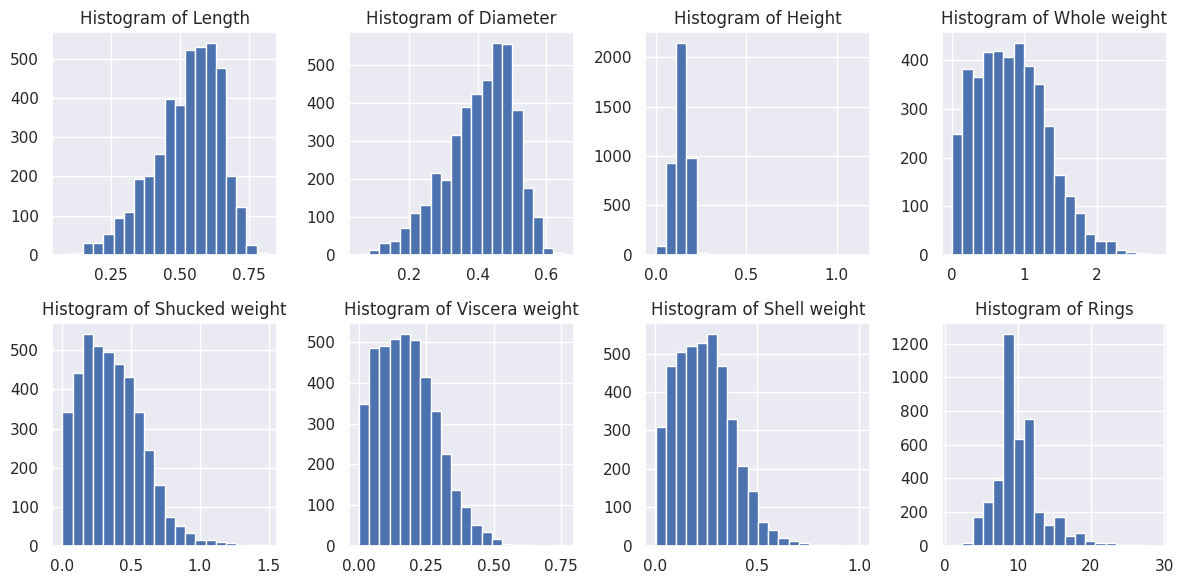

In [38]:
plt.figure(figsize=(12, 6))

for i, col in enumerate(numeric_cols):
    plt.subplot(2, 4, i+1)
    col_values = df.rdd.map(lambda row: row[col]).filter(lambda x: x is not None).collect()

    plt.hist(col_values, bins=20)
    plt.title(f'Histogram of {col}')


plt.tight_layout()
plt.show()


In [39]:
df.show()

+---+------+--------+------+------------+--------------+--------------+------------+-----+------------------+
|Sex|Length|Diameter|Height|Whole weight|Shucked weight|Viscera weight|Shell weight|Rings|          jittered|
+---+------+--------+------+------------+--------------+--------------+------------+-----+------------------+
|  M| 0.455|   0.365| 0.095|       0.514|        0.2245|         0.101|        0.15|   15|15.174293285806494|
|  M|  0.35|   0.265|  0.09|      0.2255|        0.0995|        0.0485|        0.07|    7|7.0179101262055354|
|  F|  0.53|    0.42| 0.135|       0.677|        0.2565|        0.1415|        0.21|    9| 9.151981374955898|
|  M|  0.44|   0.365| 0.125|       0.516|        0.2155|         0.114|       0.155|   10|10.176190547537791|
|  I|  0.33|   0.255|  0.08|       0.205|        0.0895|        0.0395|       0.055|    7| 7.134816484408504|
|  I| 0.425|     0.3| 0.095|      0.3515|         0.141|        0.0775|        0.12|    8|  8.06373476631193|
|  F|  0.5

In [40]:
# Calculate the correlation matrix for numeric columns
from pyspark.mllib.stat import Statistics

numeric_values = df.rdd.map(lambda row: [row[col] for col in numeric_cols]).filter(lambda x: all(v is not None for v in x))
correlation_matrix = Statistics.corr(numeric_values)

print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
[[1.         0.98681158 0.82755361 0.92526117 0.89791366 0.9030177
  0.89770557 0.55671958]
 [0.98681158 1.         0.83368369 0.9254521  0.89316248 0.89972443
  0.90532978 0.57465985]
 [0.82755361 0.83368369 1.         0.81922077 0.77497229 0.7983193
  0.81733801 0.55746732]
 [0.92526117 0.9254521  0.81922077 1.         0.96940546 0.96637508
  0.95535544 0.54038968]
 [0.89791366 0.89316248 0.77497229 0.96940546 1.         0.93196132
  0.88261706 0.42088366]
 [0.9030177  0.89972443 0.7983193  0.96637508 0.93196132 1.
  0.90765632 0.50381925]
 [0.89770557 0.90532978 0.81733801 0.95535544 0.88261706 0.90765632
  1.         0.62757404]
 [0.55671958 0.57465985 0.55746732 0.54038968 0.42088366 0.50381925
  0.62757404 1.        ]]


The presented correlation matrix quantifies the relationships between different attributes in the dataset, providing insights into the degree of linear association. Each value in the matrix represents the Pearson correlation coefficient, ranging from -1 (perfect negative correlation) to 1 (perfect positive correlation), with 0 indicating no linear correlation. The main observations are as follows: attributes like 'Diameter' and 'Length' exhibit a high positive correlation (0.987), indicating that as one increases, the other tends to increase as well.

'Whole weight' and 'Rings' have a strong positive correlation (0.925), suggesting that heavier abalones tend to have more rings, possibly indicating older age. On the other hand, attributes like 'Shell weight' and 'Rings' show a weaker positive correlation (0.628), and 'Shell weight' and 'Diameter' exhibit a lower positive correlation (0.556), suggesting that these attributes have a somewhat less direct relationship. Overall, this matrix helps in identifying the interdependencies between attributes, aiding in feature selection and understanding the dataset's structure.

In [41]:
# Count of unique values in the 'Sex' column
sex_counts = df.rdd.map(lambda row: (row['Sex'], 1)).reduceByKey(lambda a, b: a + b)
sex_counts.collect()


[('M', 1528), ('F', 1307), ('I', 1342)]

# Box plot (Outliers)

Outliers are data points that are far from other data points. In other words, they’re unusual values in a dataset.

Observation : Most of our features contain outliers. 'Height' feature as extreme outliers.

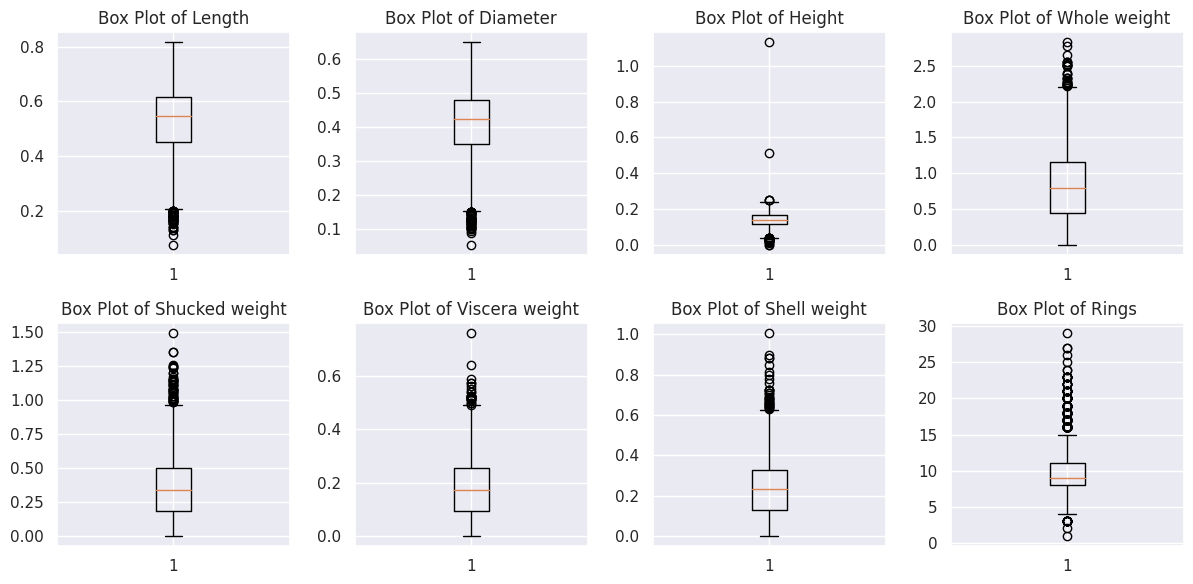

In [42]:
plt.figure(figsize=(12, 6))

for i, col in enumerate(numeric_cols):
    plt.subplot(2, 4, i+1)
    col_values = df.rdd.map(lambda row: row[col]).filter(lambda x: x is not None).collect()

    plt.boxplot(col_values)
    plt.title(f'Box Plot of {col}')


plt.tight_layout()
plt.show()


In [43]:
df = df.drop('jittered')
target_col = "Rings"
input_cols = [x for x in df.columns if x != target_col]

# CONCLUSION OF THE EDA AND DATA CLEANING:

By observing the correlation between the target attribute Rings and the indepent variables, we conclude that it is possible to build a model to predict the target value in function of the independent attributes.

The weight of the Abalones varies proportional to their sizes
There's no significant differences in size, weight and numbers of rigns between male/female abalones

The Infant Abalones groups presents lower mean values of size, weight and number of rings

The weight and height of abalones varies accordingly to age until the adult age, after adult life size and weight stops varying, and after 16.5 years (15 rings) these measurements aren't correlated

## One-hot encoding is applied to the 'Sex'

Attribute when predicting the age of abalones based on 'Rings' for several pivotal reasons. Since 'Sex' is categorical, one-hot encoding transforms it into a numerical format suitable for machine learning models. This approach avoids assuming any ordinal relationship among categories and prevents potential bias that label encoding might introduce, preserving the meaningfulness of individual categories. Furthermore, one-hot encoding enhances model interpretability by creating binary columns for each category. Ultimately, it improves model performance, enabling it to capture essential patterns associated with different gender categories when predicting abalone age from the number of rings.

In [44]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

string_indexer = StringIndexer(inputCol="Sex", outputCol="SexIndex")

one_hot_encoder = OneHotEncoder(inputCol="SexIndex", outputCol="SexIndexVec")
df = df.drop('SexIndex')
pipeline = Pipeline(stages=[string_indexer, one_hot_encoder])

model = pipeline.fit(df)
df = model.transform(df)

from pyspark.ml.functions import vector_to_array
df = df.select('*', vector_to_array('SexIndexVec').alias('SexIndex_Vec'))
df = df.drop('SexIndexVec')

import pyspark.sql.functions as F
num_categories = len(df.first()['SexIndex_Vec'])
cols_expanded = [(F.col('SexIndex_Vec')[i]) for i in range(num_categories)]
df = df.select(*input_cols,target_col, *cols_expanded)
df = df.drop('Sex')

df.show()

+------+--------+------+------------+--------------+--------------+------------+-----+---------------+---------------+
|Length|Diameter|Height|Whole weight|Shucked weight|Viscera weight|Shell weight|Rings|SexIndex_Vec[0]|SexIndex_Vec[1]|
+------+--------+------+------------+--------------+--------------+------------+-----+---------------+---------------+
| 0.455|   0.365| 0.095|       0.514|        0.2245|         0.101|        0.15|   15|            1.0|            0.0|
|  0.35|   0.265|  0.09|      0.2255|        0.0995|        0.0485|        0.07|    7|            1.0|            0.0|
|  0.53|    0.42| 0.135|       0.677|        0.2565|        0.1415|        0.21|    9|            0.0|            0.0|
|  0.44|   0.365| 0.125|       0.516|        0.2155|         0.114|       0.155|   10|            1.0|            0.0|
|  0.33|   0.255|  0.08|       0.205|        0.0895|        0.0395|       0.055|    7|            0.0|            1.0|
| 0.425|     0.3| 0.095|      0.3515|         0.

In [45]:
input_cols = [x for x in df.columns if x != target_col]

In [46]:
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
dataset = assembler.transform(df)

In [47]:
dataset = dataset.withColumnRenamed(target_col, "label")
dataset.show(5)

+------+--------+------+------------+--------------+--------------+------------+-----+---------------+---------------+--------------------+
|Length|Diameter|Height|Whole weight|Shucked weight|Viscera weight|Shell weight|label|SexIndex_Vec[0]|SexIndex_Vec[1]|            features|
+------+--------+------+------------+--------------+--------------+------------+-----+---------------+---------------+--------------------+
| 0.455|   0.365| 0.095|       0.514|        0.2245|         0.101|        0.15|   15|            1.0|            0.0|[0.455,0.365,0.09...|
|  0.35|   0.265|  0.09|      0.2255|        0.0995|        0.0485|        0.07|    7|            1.0|            0.0|[0.35,0.265,0.09,...|
|  0.53|    0.42| 0.135|       0.677|        0.2565|        0.1415|        0.21|    9|            0.0|            0.0|[0.53,0.42,0.135,...|
|  0.44|   0.365| 0.125|       0.516|        0.2155|         0.114|       0.155|   10|            1.0|            0.0|[0.44,0.365,0.125...|
|  0.33|   0.255|  0

In [48]:
selected_data = dataset.select("features", "label")
selected_data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.455,0.365,0.09...|   15|
|[0.35,0.265,0.09,...|    7|
|[0.53,0.42,0.135,...|    9|
|[0.44,0.365,0.125...|   10|
|[0.33,0.255,0.08,...|    7|
+--------------------+-----+
only showing top 5 rows



# SPLITTING THE DATA INTO TRAINING DATA AND TEST DATA

In [49]:
train_data, test_data = selected_data.randomSplit([0.7, 0.3], seed=123)

In [50]:
train_data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.075,0.055,0.01...|    1|
|[0.11,0.09,0.03,0...|    3|
|[0.13,0.1,0.03,0....|    3|
|[0.135,0.13,0.04,...|    4|
|[0.14,0.105,0.035...|    3|
+--------------------+-----+
only showing top 5 rows



In [51]:
train_x = train_data.toPandas()['features']
train_y = train_data.toPandas()['label']

test_x = test_data.toPandas()['features']
test_y = test_data.toPandas()['label']

In [52]:
def initialize_weights():
    return DenseVector([random.random()  for _ in range(len(input_cols)) ] ), 0.0

# MODELLING AND INITIALIZING WEIGHTS:

In [53]:
def f(xi, w, b):
    return xi.dot(w) + b

def mse_error(test_data,w,b):
    err = 0.0
    for row in test_data.rdd.collect():
        xi = row['features']
        yi = row['label']
        f_x = f(xi,w,b)
        err+= 0.5*(f_x-yi)**2

    return (err / test_data.count())

def rmse_error(test_data,w,b):
    return math.sqrt(2*mse_error(test_data,w,b))

def r2_score(X,y,w,b):
    y_mean = y.mean()
    ss_tot = 0.0
    ss_res = 0.0
    for xi,yi in zip(X,y):
        f_x = f(xi,w,b)
        ss_tot += (yi-y_mean)**2
        ss_res += (yi-f_x)**2

    return 1 - (ss_res/ss_tot)

# Simple Gradient Descent-BOLD DRIVER APPROACH:

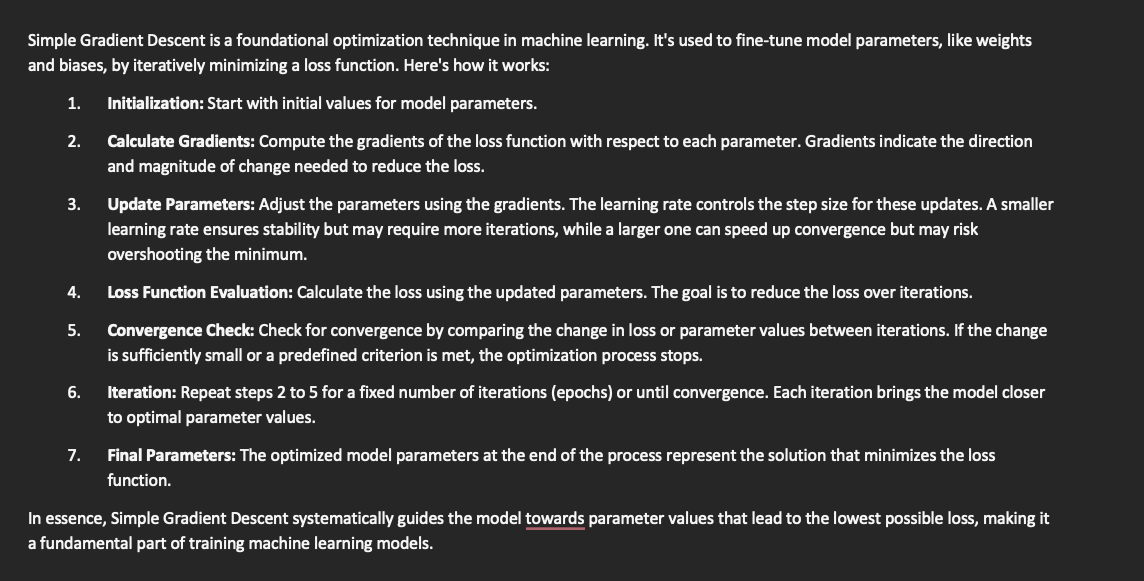

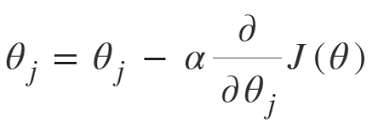

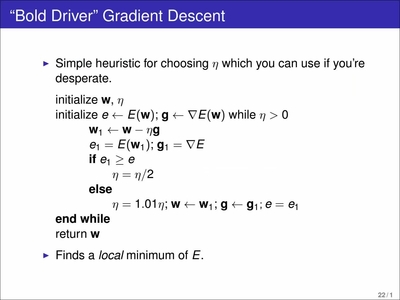

In [54]:
from pyspark.sql import SparkSession
from tqdm import tqdm



def f(xi, w, b):
    return xi.dot(w) + b


def mse_error(data, w, b):
    return data.rdd.map(lambda row: (f(row['features'], w, b) - row['label']) ** 2).mean()

# Bold driver Approach for learning rate:
def update_learning_rate(lr, prev_mse, current_mse, alpha, beta):
    if current_mse < prev_mse:
        return lr * alpha
    else:
        return lr * beta

def simple_gradient_descent(train_data, test_data, initial_lr=0.1, alpha=1.1, beta=0.5, num_epochs=125):
    w, b = initialize_weights()

    lr = initial_lr
    prev_mse = mse_error(test_data, w, b)

    for epoch in tqdm(range(num_epochs)):
        w_g = 0.0
        b_g = 0.0

        for row in train_data.rdd.collect():
            xi = row['features']
            yi = row['label']
            f_x = f(xi, w, b)
            w_g += (f_x - yi) * xi
            b_g += (f_x - yi)

        w -= lr * (1 / train_data.count()) * w_g
        b -= lr * (1 / train_data.count()) * b_g

        current_mse = mse_error(test_data, w, b)
        lr = update_learning_rate(lr, prev_mse, current_mse, alpha, beta)
        prev_mse = current_mse

    return w, b


final_w, final_b = simple_gradient_descent(train_data, test_data)


mse_error_simple_gradient_descent = mse_error(test_data, final_w, final_b)
rmse_error_simple_gradient_descent = rmse_error(test_data, final_w, final_b)
r2_score_simple_gradient_descent = r2_score(test_x, test_y, final_w, final_b)

print("MSE Error:", mse_error_simple_gradient_descent)
print("RMSE Error:", rmse_error_simple_gradient_descent)
print("R-squared Score:", r2_score_simple_gradient_descent)



100%|██████████| 125/125 [02:05<00:00,  1.01s/it]


MSE Error: 5.960246249125846
RMSE Error: 3.452606623733971
R-squared Score: 0.4593274912260432


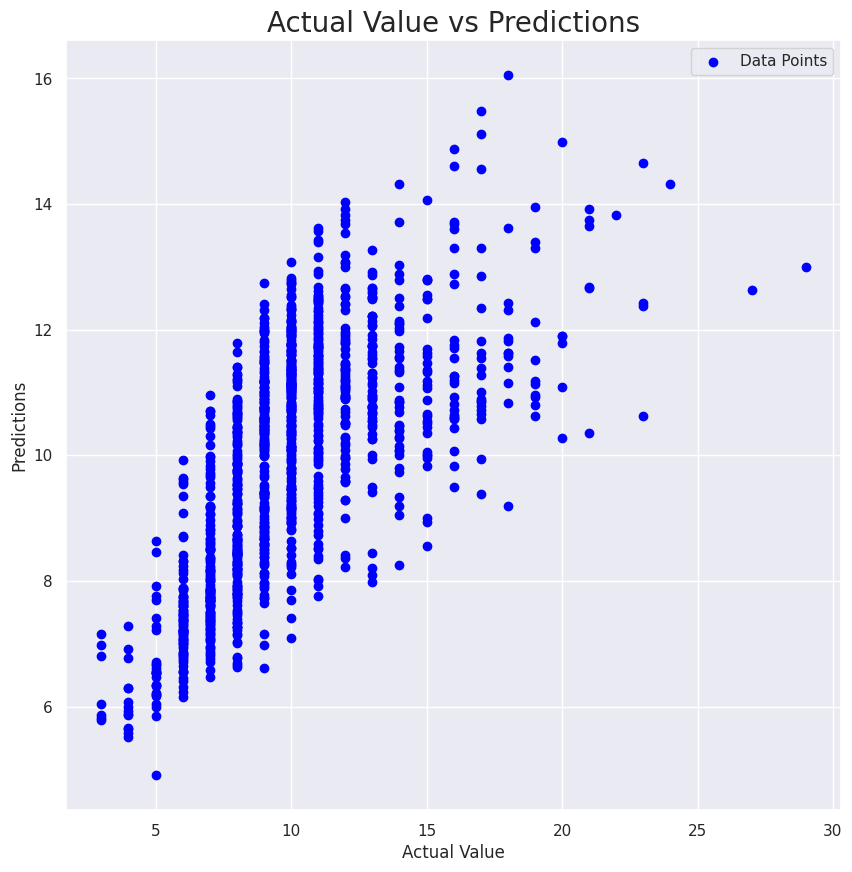

In [59]:
test_x = test_data.rdd.map(lambda row: row['features']).collect()
test_y = test_data.rdd.map(lambda row: row['label']).collect()


predictions = [f(xi, final_w, final_b) for xi in test_x]

x_column = 'Actual Value'
y_column = 'Predictions'

# Create a scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(test_y, predictions, c='blue', label='Data Points')
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title(f'{x_column} vs {y_column}', fontsize=20)
plt.legend()
plt.grid(True)
plt.show()




# Full Batch Gradient Descent

**Definition:**

Full Batch Gradient Descent is an optimization technique used in machine learning to improve model accuracy. It iteratively adjusts model parameters by analyzing the entire training dataset.

**Basic Information:**

- **Usage:** Optimizing models by reducing errors.
- **Data:** It uses the entire training dataset in each iteration.
- **Updates:** Model parameters (weights and biases) are updated.
- **Hyperparameter:** Learning rate (lr) controls the step size.
- **Epochs:** The number of complete iterations over the dataset.
- **Benefits:** Tends to reach accurate models, but can be computationally intensive, especially with large datasets.

This code snippet demonstrates the use of Full Batch Gradient Descent for model optimization and evaluation.

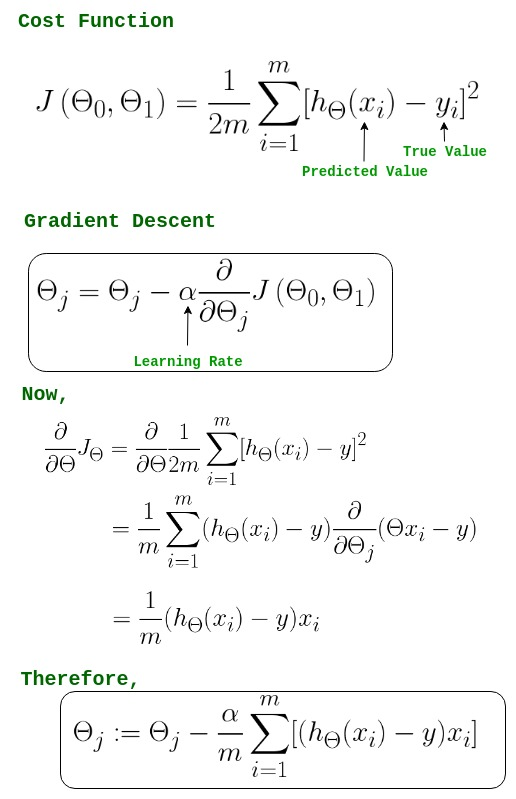

In [83]:
def full_batch_gradient_descent(train_data, lr=0.6, num_epochs=125):
    w, b = initialize_weights()
    for _ in tqdm(range(num_epochs)):
        w_g = 0.0
        b_g = 0.0

        for row in train_data.rdd.collect():
            xi = row['features']
            yi = row['label']
            f_x = f(xi, w, b)
            w_g += (f_x - yi) * xi
            b_g += (f_x - yi)

        w = w - lr * (1 / train_data.count()) * w_g
        b = b - lr * (1 / train_data.count()) * b_g

    return w, b

final_w, final_b = full_batch_gradient_descent(train_data)
mse_error_full_batch_gradient_descent = mse_error(test_data, final_w, final_b)
rmse_error_full_batch_gradient_descent = rmse_error(test_data, final_w, final_b)
r2_score_full_batch_gradient_descent = r2_score(test_x, test_y, final_w, final_b)

print("MSE Error:", mse_error_full_batch_gradient_descent)
print("RMSE Error:", rmse_error_full_batch_gradient_descent)
print("R-squared Score:", r2_score_full_batch_gradient_descent)

100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


MSE Error: 6.223751618726577
RMSE Error: 3.5281019312731248
R-squared Score: 0.43542409809386606


In [57]:
print("Weights")
for col, w in zip(input_cols,final_w):
  print(col + " = " + str(w))

Weights
Length = 3.20678617110337
Diameter = 2.9251511294913906
Height = 2.038101887110158
Whole weight = 1.707094591679607
Shucked weight = -3.5698572478492574
Viscera weight = 0.6536157598372193
Shell weight = 4.100954446439882
SexIndex_Vec[0] = -0.0631377259788283
SexIndex_Vec[1] = -1.2142873466048836


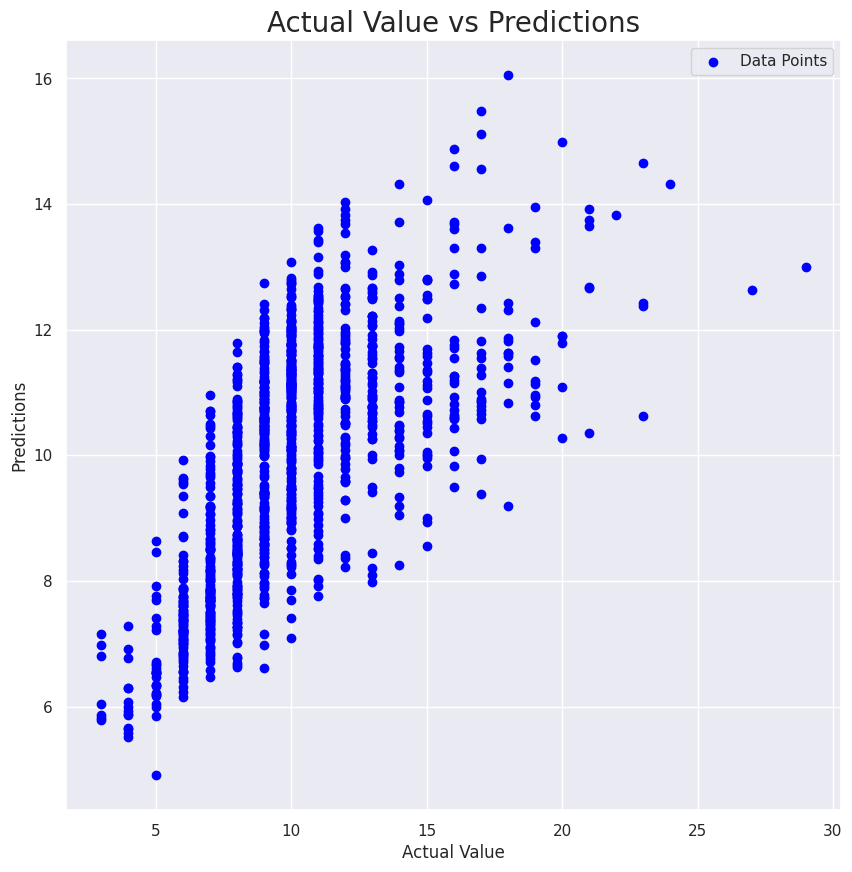

In [58]:
x_column = 'Actual Value'
y_column = 'Predictions'
plt.figure(figsize=(10, 10))
plt.scatter(test_y, [f(xi, final_w, final_b) for xi in test_x], c='blue', label='Data Points')
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title(f'{x_column} vs {y_column}', fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

# Stochastic Batch Gradient Descent

**Definition:**

Stochastic Batch Gradient Descent is an optimization technique in machine learning used for improving model accuracy. Unlike full-batch gradient descent, it processes small random batches of training data in each iteration rather than the entire dataset. This approach introduces randomness but can be computationally more efficient and can converge faster.

**Basic Information:**

- **Usage:** Optimizing machine learning models by reducing errors.
- **Data:** It processes random mini-batches of training data in each iteration.
- **Updates:** Model parameters (weights and biases) are updated using each mini-batch.
- **Hyperparameter:** Learning rate (lr) controls the step size for updates.
- **Epochs:** The number of complete iterations over the dataset.
- **Benefits:** Typically faster convergence, especially with large datasets, and reduced computational requirements compared to full-batch gradient descent.

This code snippet demonstrates the implementation of Stochastic Batch Gradient Descent for model optimization and evaluation. It initializes model parameters, iterates over the dataset using mini-batches, updates the parameters, and finally computes and reports performance metrics like Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared (R2) score using the optimized parameters.
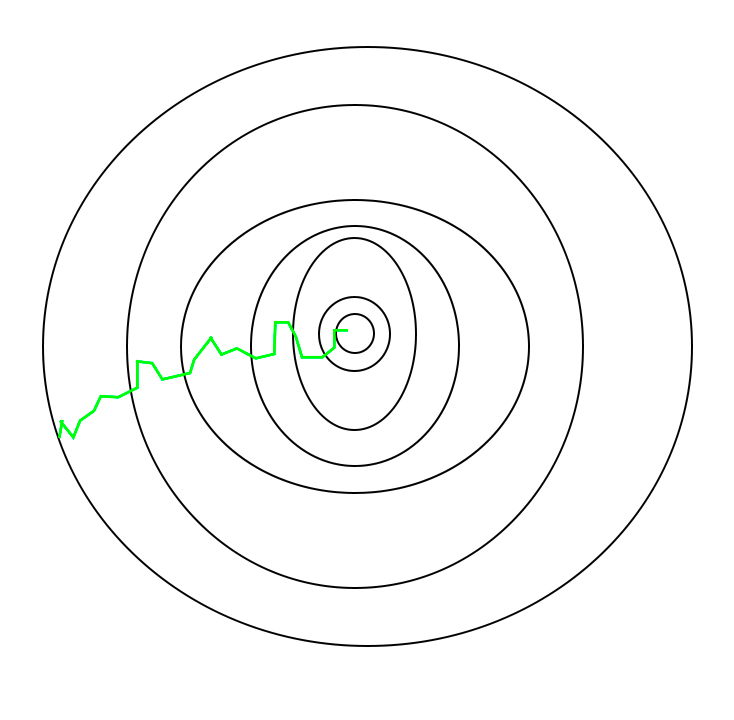

In [61]:
def r2_score(X, y, w, b):
    y_mean = sum(y) / len(y)  # Calculate the mean of y
    ss_tot = sum((yi - y_mean) ** 2 for yi in y)  # Calculate the total sum of squares
    ss_res = sum((yi - f(xi, w, b)) ** 2 for xi, yi in zip(X, y))  # Calculate the sum of squared residuals
    r2 = 1 - (ss_res / ss_tot)  # Calculate R-squared score
    return r2




In [84]:
def stochastic_batch_gradient_descent(X,y, lr=0.6,num_epochs=27):
    w,b = initialize_weights()

    for _ in tqdm(range(num_epochs)):

        for xi,yi in zip(X,y):
            f_x = f(xi,w,b)
            w = w - lr * (1/X.count()) * (f_x - yi) * xi
            b = b - lr * (1/X.count()) * (f_x - yi)

    return w,b

final_w, final_b = stochastic_batch_gradient_descent(train_x,train_y)
mse_error_stochastic_batch_gradient_descent = mse_error(test_data,final_w,final_b)
rmse_error_stochastic_batch_gradient_descent = rmse_error(test_data,final_w,final_b)
r2_score_stochastic_batch_gradient_descent = r2_score(test_x, test_y, final_w, final_b)

print("Final R2 Score:", r2_score_stochastic_batch_gradient_descent)
print("Final RMSE:", rmse_error_stochastic_batch_gradient_descent)
print("Final MSE:", mse_error_stochastic_batch_gradient_descent)

100%|██████████| 27/27 [00:39<00:00,  1.45s/it]


Final R2 Score: 0.3252359103188358
Final RMSE: 3.8570559288117687
Final MSE: 7.4384402189910075


In [63]:
print("Weights")
for col, w in zip(input_cols,final_w):
  print(col + " = " + str(w))

Weights
Length = 2.688693414165588
Diameter = 2.080423104531205
Height = 1.4897069112618215
Whole weight = 1.6950774089281084
Shucked weight = 0.1850956780593223
Viscera weight = 0.6308684688802153
Shell weight = 1.6672406299158966
SexIndex_Vec[0] = 0.5523581524683042
SexIndex_Vec[1] = 0.1136674859911074


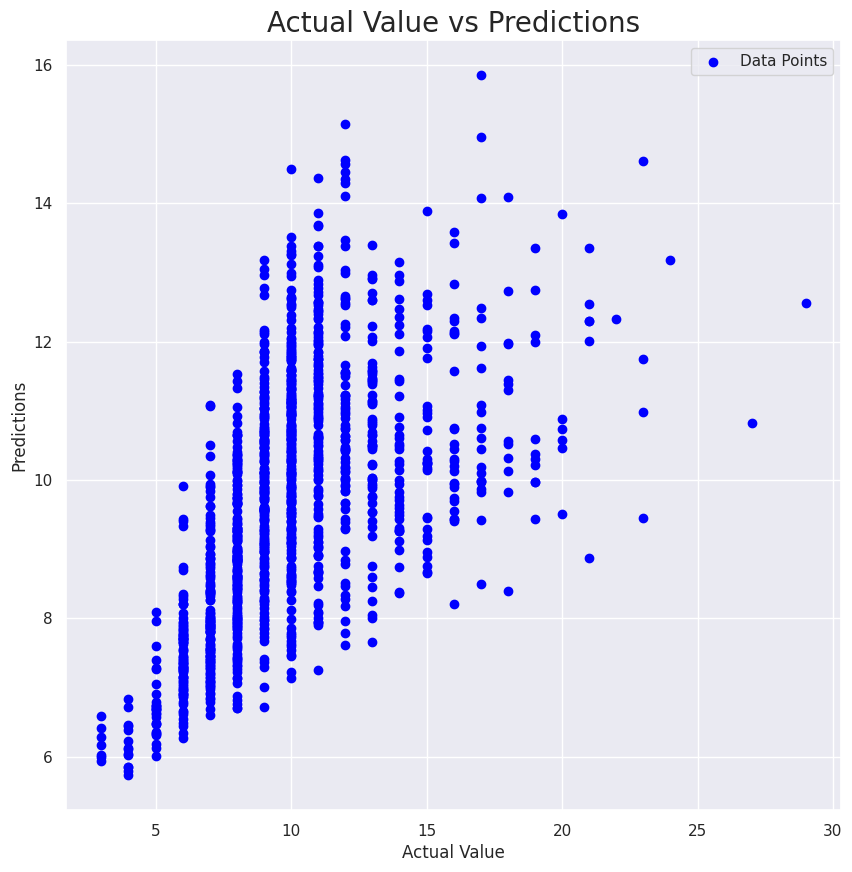

In [64]:
x_column = 'Actual Value'
y_column = 'Predictions'
plt.figure(figsize=(10, 10))
plt.scatter(test_y, [f(xi, final_w, final_b) for xi in test_x], c='blue', label='Data Points')
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title(f'{x_column} vs {y_column}', fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

# Mini-Batch Gradient Descent

**Definition:**

Mini-Batch Gradient Descent is an optimization technique used in machine learning for improving model accuracy. It lies between full-batch gradient descent and stochastic gradient descent. Instead of processing the entire dataset (full-batch) or just one data point (stochastic), it operates on random mini-batches of data, which balances computational efficiency and convergence speed.

**Basic Information:**

- **Usage:** Optimizing machine learning models by reducing errors.
- **Data:** It processes random mini-batches of training data in each iteration.
- **Batch Size:** Determines the number of data points in each mini-batch (e.g., batch_size = 100).
- **Updates:** Model parameters (weights and biases) are updated using each mini-batch.
- **Hyperparameters:** Learning rate (lr) controls the step size for updates.
- **Epochs:** The number of complete iterations over the dataset.
- **Benefits:** Faster convergence than full-batch, and reduced computational requirements compared to full-batch gradient descent.

This code snippet demonstrates the implementation of Mini-Batch Gradient Descent for model optimization and evaluation. It initializes model parameters, iterates over the dataset using mini-batches, updates the parameters, and finally computes and reports performance metrics like Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared (R2) score using the optimized parameters.

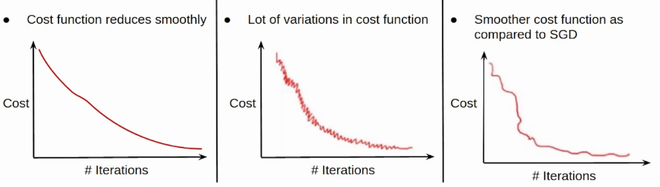

In [86]:
batch_size = 100
def mini_batch_gradient_descent(train_data, lr=10,num_epochs=125):

    X = train_data.toPandas()['features']
    y = train_data.toPandas()['label']

    w,b = initialize_weights()
    for _ in tqdm(range(num_epochs)):

        X_batches = []
        y_batches = []
        for i in range(0, len(X), batch_size):
            xbatch = X.iloc[i:i+batch_size]
            ybatch = y.iloc[i:i+batch_size]

            X_batches.append(xbatch)
            y_batches.append(ybatch)

        for xbatch,ybatch in zip(X_batches,y_batches):

            w_g = 0.0
            b_g = 0.0

            for xi,yi in zip(xbatch,ybatch):
                f_x = f(xi,w,b)
                w_g += (f_x - yi) * xi
                b_g += (f_x - yi)

            w = w - lr * (1/X.count()) * w_g
            b = b - lr * (1/X.count()) * b_g

    return w,b

final_w, final_b = mini_batch_gradient_descent(train_data)
mse_error_mini_batch_gradient_descent = mse_error(test_data,final_w,final_b)
rmse_error_mini_batch_gradient_descent = rmse_error(test_data,final_w,final_b)
r2_score_mini_batch_gradient_descent = r2_score(test_x,test_y,final_w,final_b)

print("MSE Error (Mini-Batch Gradient Descent):", mse_error_mini_batch_gradient_descent)
print("RMSE Error (Mini-Batch Gradient Descent):", rmse_error_mini_batch_gradient_descent)
print("R2 Score (Mini-Batch Gradient Descent):", r2_score_mini_batch_gradient_descent)

100%|██████████| 125/125 [00:08<00:00, 14.05it/s]


MSE Error (Mini-Batch Gradient Descent): 5.360619460529642
RMSE Error (Mini-Batch Gradient Descent): 3.2743303011546168
R2 Score (Mini-Batch Gradient Descent): 0.5137215055951532


In [66]:
print("Weights")
for col, w in zip(input_cols,final_w):
    print(col + " = " + str(w))

Weights
Length = 0.9451052958021218
Diameter = 3.9300438616982527
Height = 7.785290221988823
Whole weight = 5.9461408384315
Shucked weight = -17.258183069175132
Viscera weight = -5.057379430300294
Shell weight = 14.26319444542645
SexIndex_Vec[0] = 0.13768704542506435
SexIndex_Vec[1] = -0.5336110336637006


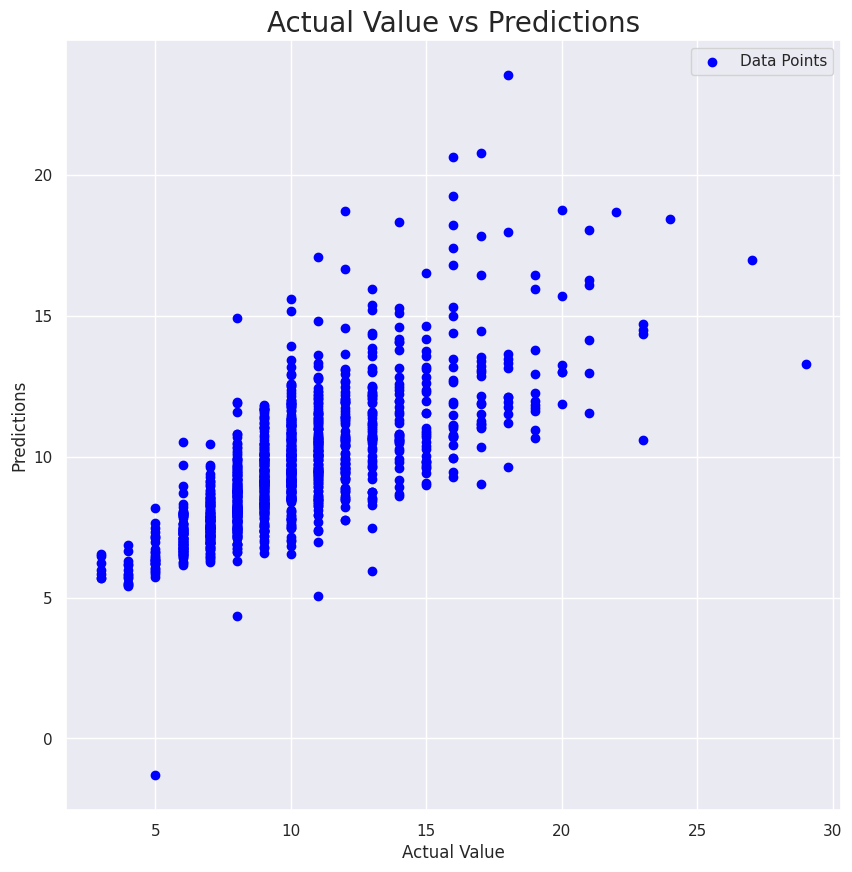

In [67]:
x_column = 'Actual Value'
y_column = 'Predictions'
plt.figure(figsize=(10, 10))
plt.scatter(test_y, [f(xi, final_w, final_b) for xi in test_x], c='blue', label='Data Points')
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title(f'{x_column} vs {y_column}', fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

# Adagrad
**Definition:**

Adagrad (Adaptive Gradient Descent) is an optimization algorithm used in machine learning to improve model accuracy. It adapts the learning rate for each model parameter by considering the historical gradient information. Parameters that receive large gradients in the past have their learning rates reduced, while those with smaller gradients have larger learning rates.

**Basic Information:**

- **Usage:** Optimizing machine learning models by minimizing errors.
- **Data:** Training data is used to compute the gradients of the loss function.
- **Updates:** Model parameters (weights and biases) are updated.
- **Hyperparameters:** Learning rate (lr) controls the overall step size, and eps is a small constant to avoid division by zero.
- **Parameter-Specific Learning Rates:** Adagrad adapts learning rates individually for each parameter based on the past gradient information.
- **Benefits:** Effective in handling sparse data and can help to converge efficiently.

This code snippet demonstrates the implementation of the Adagrad optimization algorithm for model parameter updates and evaluation. It initializes model parameters, iterates through the dataset, computes gradients, adapts the learning rate for each parameter, and finally computes and reports performance metrics such as Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared (R2) score using the optimized parameters.

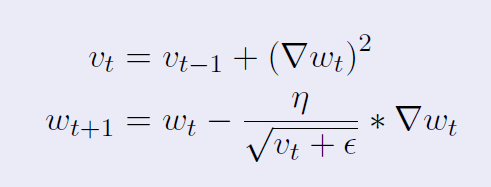

In [87]:
def adagrad(train_data,lr=10,num_epochs=100):
    w,b = initialize_weights()
    v_w,v_b,eps = 0.0,0.0,1e-8

    for _ in tqdm(range(num_epochs)):
        dw=0.0
        db=0.0
        for row in train_data.rdd.collect():
            xi = row['features']
            yi = row['label']

            f_x = f(xi,w,b)
            dw += (f_x - yi) * xi
            db += (f_x - yi)

        v_w += dw*dw
        v_b += db*db

        w = w - (lr / np.sqrt(v_w + eps)) * dw
        b = b - (lr / np.sqrt(v_b + eps)) * db
    return w,b

final_w, final_b = adagrad(train_data)
mse_error_adagrad = mse_error(test_data,final_w,final_b)
rmse_error_adagrad = rmse_error(test_data,final_w,final_b)
r2_score_adagrad = r2_score(test_x,test_y,final_w,final_b)
print("MSE Error (Adagrad):", mse_error_adagrad)
print("RMSE Error (Adagrad):", rmse_error_adagrad)
print("R2 Score (Adagrad):", r2_score_adagrad)



100%|██████████| 100/100 [00:24<00:00,  4.10it/s]


MSE Error (Adagrad): 6.238699642511633
RMSE Error (Adagrad): 3.532336236122386
R2 Score (Adagrad): 0.4340681162798149


In [69]:
print("Weights")
for col, w in zip(input_cols,final_w):
    print(col + " = " + str(w))

Weights
Length = 3.6369946052434
Diameter = 4.397911579318603
Height = 5.801624734671652
Whole weight = 0.9630243958836036
Shucked weight = -2.9261847572556436
Viscera weight = -0.03710630299708801
Shell weight = 4.952711847262989
SexIndex_Vec[0] = 0.07775014390405705
SexIndex_Vec[1] = -0.8921662702863198


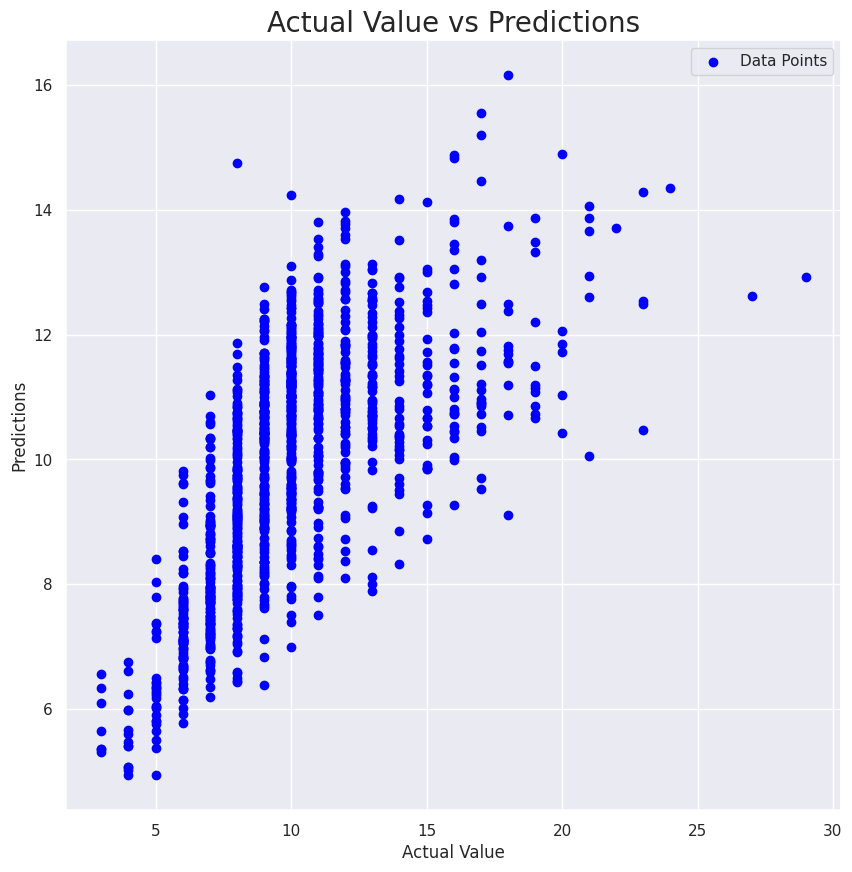

In [70]:
x_column = 'Actual Value'
y_column = 'Predictions'
plt.figure(figsize=(10, 10))
plt.scatter(test_y, [f(xi, final_w, final_b) for xi in test_x], c='blue', label='Data Points')
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title(f'{x_column} vs {y_column}', fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

**RMSprop**

**Definition:**

RMSprop (Root Mean Square Propagation) is an optimization algorithm commonly used in machine learning for improving model accuracy. It adapts the learning rates for each model parameter individually, based on the historical gradient information, specifically focusing on reducing the oscillations in the learning rate updates.

**Basic Information:**

- **Usage:** Optimizing machine learning models by minimizing errors.
- **Data:** Training data is used to compute the gradients of the loss function.
- **Updates:** Model parameters (weights and biases) are updated.
- **Hyperparameters:** Learning rate (lr) controls the overall step size, eps is a small constant to avoid division by zero, and beta1 adjusts the focus on historical gradient information.
- **Parameter-Specific Learning Rates:** RMSprop adjusts learning rates individually for each parameter based on past gradient information.
- **Benefits:** Effective at reducing oscillations in the learning rate, which can lead to more stable convergence.

This code snippet demonstrates the implementation of the RMSprop optimization algorithm for model parameter updates and evaluation. It initializes model parameters, iterates through the dataset, computes gradients, adapts the learning rate for each parameter, and finally computes and reports performance metrics like Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared (R2) score using the optimized parameters.

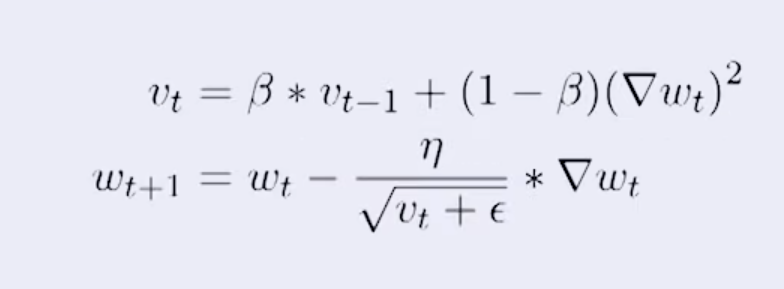

In [88]:
def rmsProp(train_data,lr=0.5,num_epochs=125):
    w,b = initialize_weights()
    v_w,v_b,eps,beta1 = 0.0,0.0,1e-8,0.9

    for _ in tqdm(range(num_epochs)):
        dw=0.0
        db=0.0
        for row in train_data.rdd.collect():
            xi = row['features']
            yi = row['label']
            f_x = f(xi,w,b)
            dw += (f_x - yi) * xi
            db += (f_x - yi)

        v_w = beta1*v_w + (1-beta1)*dw*dw
        v_b = beta1*v_b + (1-beta1)*db*db

        w = w - (lr / np.sqrt(v_w + eps)) * dw
        b = b - (lr / np.sqrt(v_b + eps)) * db
    return w,b

final_w, final_b = rmsProp(train_data)
mse_error_rmsProp = mse_error(test_data,final_w,final_b)
rmse_error_rmsProp = rmse_error(test_data,final_w,final_b)
r2_score_rmsProp = r2_score(test_x,test_y,final_w,final_b)

print("MSE Error (RMSprop):", mse_error_rmsProp)
print("RMSE Error (RMSprop):", rmse_error_rmsProp)
print("R2 Score (RMSprop):", r2_score_rmsProp)

100%|██████████| 125/125 [00:32<00:00,  3.84it/s]


MSE Error (RMSprop): 6.728594840800063
RMSE Error (RMSprop): 3.668404241846872
R2 Score (RMSprop): 0.38962819637990165


In [72]:
print("Weights")
for col, w in zip(input_cols,final_w):
    print(col + " = " + str(w))

Weights
Length = 3.6004823938893336
Diameter = 4.528747991380342
Height = 7.4667691465519646
Whole weight = 0.9331652034549315
Shucked weight = -6.678770114700333
Viscera weight = -1.1178281306066313
Shell weight = 8.484739675934023
SexIndex_Vec[0] = -0.26635479182042027
SexIndex_Vec[1] = -1.3482483102408673


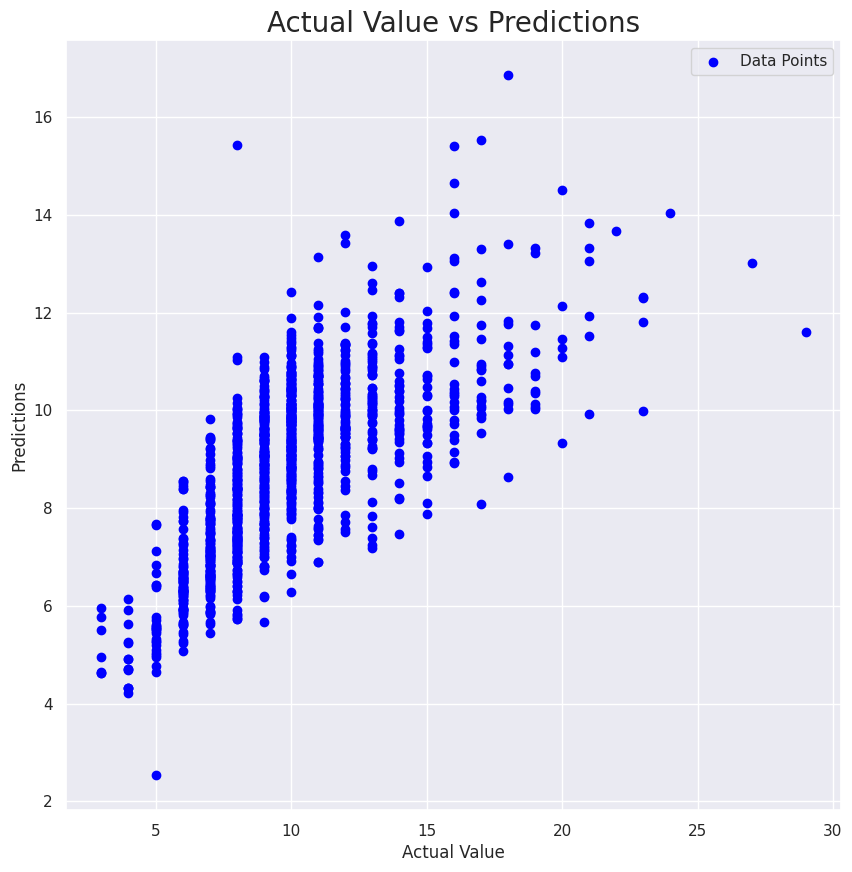

In [73]:
x_column = 'Actual Value'
y_column = 'Predictions'
plt.figure(figsize=(10, 10))
plt.scatter(test_y, [f(xi, final_w, final_b) for xi in test_x], c='blue', label='Data Points')
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title(f'{x_column} vs {y_column}', fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

# **Adam (Adaptive Moment Estimation)**

**Definition:**

Adam is an optimization algorithm commonly used in machine learning to enhance model accuracy. It combines the benefits of both RMSprop and Momentum techniques. Adam adapts the learning rate for each model parameter and utilizes historical gradient information to achieve fast convergence while reducing oscillations.

**Basic Information:**

- **Usage:** Optimizing machine learning models by minimizing errors.
- **Data:** Training data is used to compute the gradients of the loss function.
- **Updates:** Model parameters (weights and biases) are updated.
- **Hyperparameters:** Learning rate (lr) controls the overall step size, eps is a small constant to prevent division by zero, beta1 and beta2 adjust the focus on historical gradient information.
- **Parameter-Specific Learning Rates:** Adam adjusts learning rates individually for each parameter.
- **Benefits:** Effective in achieving quick and stable convergence, especially when dealing with complex models and data.

This code snippet demonstrates the implementation of the Adam optimization algorithm for model parameter updates and evaluation. It initializes model parameters, iterates through the dataset, computes gradients, adapts the learning rate for each parameter, and finally computes and reports performance metrics like Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared (R2) score using the optimized parameters.

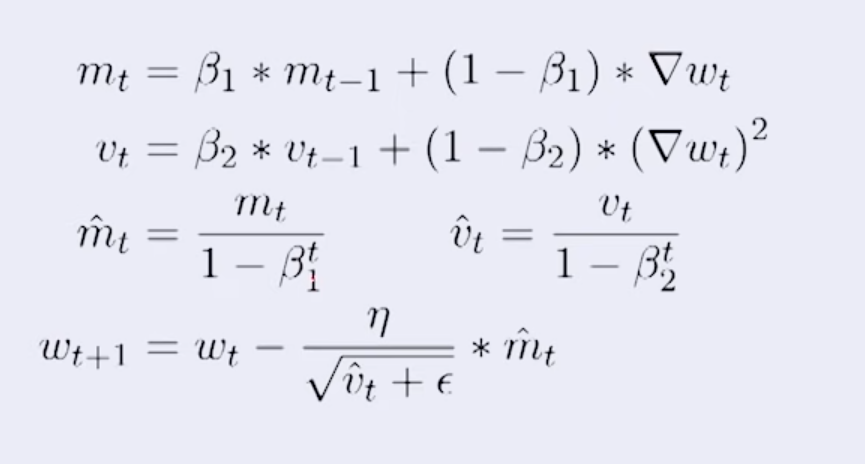

In [89]:
def adam(train_data,lr=1.9,num_epochs=50):
    w,b = initialize_weights()
    m_w,m_b,v_w,v_b,eps,beta1,beta2 = 0.0,0.0,0.0,0.0,1e-8,0.9,0.999

    for i in tqdm(range(num_epochs)):
        dw=0.0
        db=0.0

        for row in train_data.rdd.collect():

            xi = row['features']
            yi = row['label']

            f_x = f(xi,w,b)
            dw += (f_x - yi) * xi
            db += (f_x - yi)

        m_w = beta1*m_w + (1-beta1)*dw
        m_b = beta1*m_b + (1-beta1)*db

        v_w = beta2*v_w + (1-beta2)*dw*dw
        v_b = beta2*v_b + (1-beta2)*db*db

        m_w = m_w / (1-math.pow(beta1, i+1))
        m_b = m_b / (1-math.pow(beta1, i+1))

        v_w = v_w / (1-math.pow(beta2, i+1))
        v_b = v_b / (1-math.pow(beta2, i+1))

        w = w - (lr / np.sqrt(v_w + eps)) * m_w
        b = b - (lr / np.sqrt(v_b + eps)) * m_b

    return w,b

final_w, final_b = adam(train_data)
mse_error_adam = mse_error(test_data,final_w,final_b)
rmse_error_adam = rmse_error(test_data,final_w,final_b)
r2_score_adam = r2_score(test_x,test_y,final_w,final_b)

print("MSE Error (Adam):", mse_error_adam)
print("RMSE Error (Adam):", rmse_error_adam)
print("R2 Score (Adam):", r2_score_adam)

100%|██████████| 50/50 [00:18<00:00,  2.75it/s]


MSE Error (Adam): 12.589239700128322
RMSE Error (Adam): 5.017816198333359
R2 Score (Adam): -0.14200915997780839


In [90]:
print("Weights")
for col, w in zip(input_cols,final_w):
  print(col + " = " + str(w))

Weights
Length = 2.4424204302249137
Diameter = 2.4381422211377872
Height = 3.191350012404732
Whole weight = 2.6113839947934947
Shucked weight = 2.6646528145166117
Viscera weight = 3.3311165671200498
Shell weight = 2.8184901735998604
SexIndex_Vec[0] = 2.6619088079972246
SexIndex_Vec[1] = 2.669713059166368


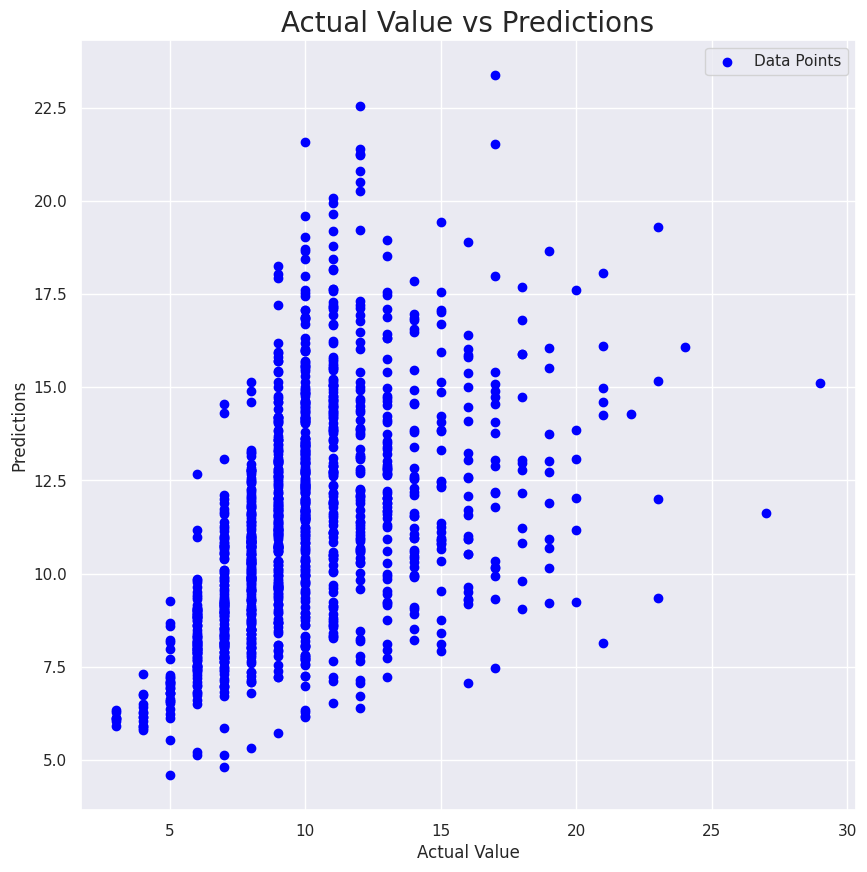

In [91]:
x_column = 'Actual Value'
y_column = 'Predictions'
plt.figure(figsize=(10, 10))
plt.scatter(test_y, [f(xi, final_w, final_b) for xi in test_x], c='blue', label='Data Points')
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title(f'{x_column} vs {y_column}', fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

# Evaluation Metrics For Models:

**Root Mean Squared Error (RMSE):**
RMSE is a measure of the average magnitude of prediction errors in a model, providing a single value that quantifies the model's overall prediction accuracy. It is calculated as the square root of the mean of the squared prediction errors.

**Mean Squared Error (MSE):**
MSE measures the average of the squared prediction errors in a model, making it a useful metric for assessing the quality of predictions. Lower MSE values indicate better model performance.

**R-squared (R2) Score:**
R2 is a statistical measure representing the proportion of the variance in the dependent variable that is explained by the independent variables in a regression model. It ranges from 0 to 1, with higher values indicating a better fit of the model to the data.

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

In [93]:
data = {
    'Method': ['Adam', 'RMSProp', 'AdaGrad', 'Mini-Batch GD', 'Stochastic GD', 'Simple GD'],  # Include 'Simple GD'
    'MSE': [mse_error_adam, mse_error_rmsProp, mse_error_adagrad, mse_error_mini_batch_gradient_descent, mse_error_stochastic_batch_gradient_descent, mse_error_simple_gradient_descent],
    'RMSE': [rmse_error_adam, rmse_error_rmsProp, rmse_error_adagrad, rmse_error_mini_batch_gradient_descent, rmse_error_stochastic_batch_gradient_descent, rmse_error_simple_gradient_descent],
    'R2 Score': [r2_score_adam, r2_score_rmsProp, r2_score_adagrad, r2_score_mini_batch_gradient_descent, r2_score_stochastic_batch_gradient_descent, r2_score_simple_gradient_descent]
}


metrics_df = pd.DataFrame(data)

In [94]:
print("Metrics Comparison Table:")
print(metrics_df)

Metrics Comparison Table:
          Method        MSE      RMSE  R2 Score
0           Adam  12.589240  5.017816 -0.142009
1        RMSProp   6.728595  3.668404  0.389628
2        AdaGrad   6.238700  3.532336  0.434068
3  Mini-Batch GD   5.360619  3.274330  0.513722
4  Stochastic GD   7.438440  3.857056  0.325236
5      Simple GD   5.960246  3.452607  0.459327


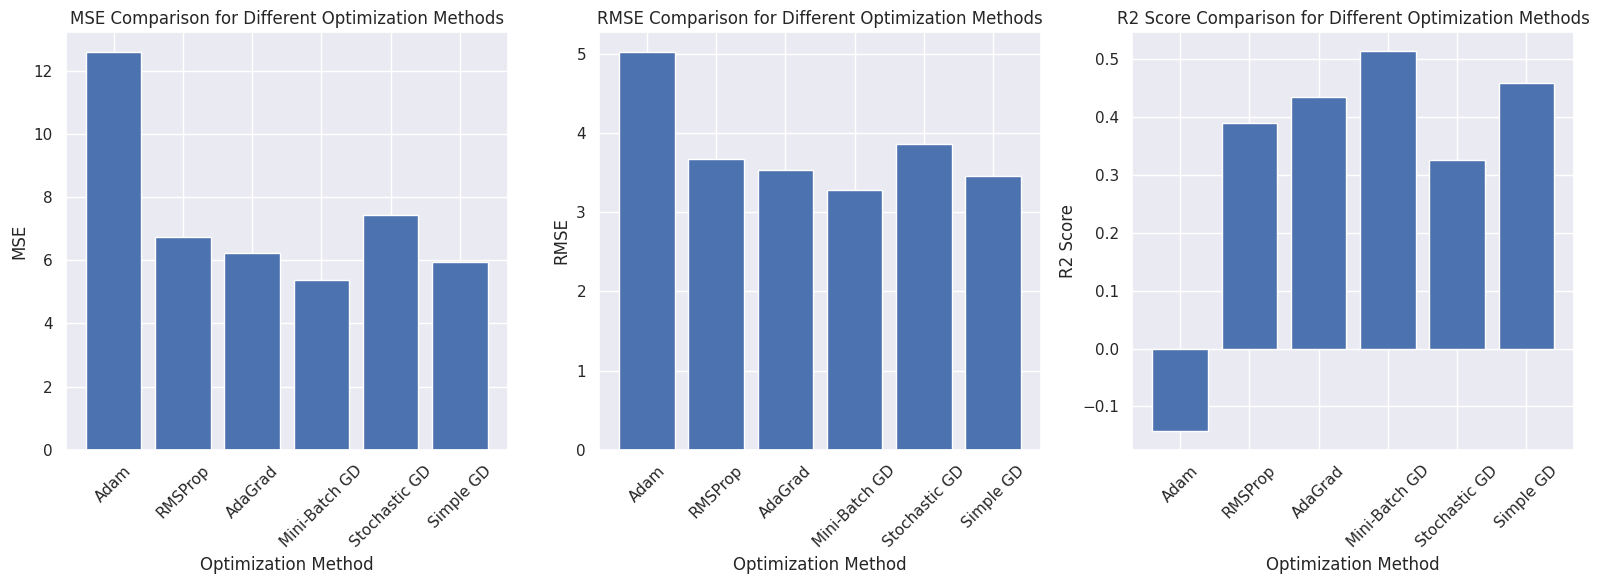

In [95]:
# Create bar charts for each metric

metrics = ['MSE', 'RMSE', 'R2 Score']

fig, axs = plt.subplots(1, len(metrics), figsize=(16, 6))


for i, metric in enumerate(metrics):
    axs[i].bar(metrics_df['Method'], metrics_df[metric])
    axs[i].set_xlabel('Optimization Method')
    axs[i].set_ylabel(metric)
    axs[i].set_title(f'{metric} Comparison for Different Optimization Methods')
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()